## 코로나19 데이터 및 전국 교통량 데이터 분석을 통한 "코로나 대확산 선행지표" 개발
- 본 분석에서는 **시기별 지역별 코로나19 확진자 수 데이터**와 전국의 **시/도 간 교통량 데이터**를 분석하여 "**코로나 대확산 선행지표**"를 개발하고자 했습니다.
<br><br>

<img src='https://img.freepik.com/free-vector/coronavirus-covid-19-pandemic-outbreak-virus-background-concept_1017-24318.jpg?size=626&ext=jpg&ga=GA1.2.49909314.1597363200' height="200"/>
<br><br>

- 최근 전문가들은 외출 등 야외활동이 곧 코로나19 확산 위험을 높이는 행동이기 때문에, 전 국민들이 가급적 외출을 자제할 것을 지속적으로 권고하고 있습니다.
### **중대본 "수도권→전국 확산 우려…서울·경기 주민, 지방 이동 자제해야"**
([참고 기사 링크](http://www.sisa-news.com/news/article.html?no=132290))
<br>
<img src='https://www.sisa-news.com/data/photos/20200833/art_159757056246_fd46b7.jpg' height="300"/>
<br><br>

- 이와 같은 전문가들의 권고를 토대로, 본 분석에서는 '**사람들의 이동량이 많을수록 코로나19 전파가 빠르게 일어났을 것**'이라는 가설을 세웠습니다. 그리고 이 가설이 타당하다면 이를 바탕으로 **코로나19 대확산이 일어날 위험도를 예측하는 선행지표**를 개발할 수 있을 것이라고 생각했습니다.
<br><br>

- 보다 구체적으로, 본 분석에서는 아래와 같은 두 가지 가설을 검증하고자 했습니다.
1. **시기별로 보았을 때, 전국의 교통량 변화 추이와 코로나19 확진자 발생 추이 사이에 관계가 있을 것이다**
2. **지역별로 보았을 때, 지역 간 이동 교통량(지역 간 연결성)과 지역 간 코로나19 전파량 사이에 관계가 있을 것이다**
<br><br>

<img src='https://image.freepik.com/free-vector/public-transport-flat-design_23-2147536140.jpg' height="400"/>
<br><br>

- 여러 데이터를 다각도로 분석한 결과, 현재까지 아래와 같은 결론을 얻을 수 있었습니다.
<br>
(추후 지속적인 업데이트를 통해 발전사항을 반영하도록 하겠습니다.)
1. **시기별로 보았을 때, 전 주 대비 교통량이 급증한 주간에 대규모 집단감염이 발생할 위험이 높아졌다**
2. **지역별로 보았을 때, 대중교통/고속도로 이동량으로 확인되는 "지역 간 연결성"이 서로 높은 지역들은 "코로나19 지역 간 전파"가 발생할 위험 또한 높아졌다.**

## 목차
- 환경 세팅
- 사용 데이터
1. 날짜별 전국 코로나19 확진자 수 데이터 분석
2. 코로나19 감염사례 데이터 분석
3. 발권 OD 데이터 분석
4. 교통카드 OD 데이터 분석
5. DSRC 데이터 분석
6. 코로나 대확산 선행지표 개발
7. 결론

## 환경세팅
- 분석환경 : 주피터 노트북

In [1]:
# # 구글 드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install geopandas

>>> 라이브러리 버전 :
pandas : 1.0.5		 numpy : 1.16.5		 sklearn : 0.23.1  |  
geopandas : 0.8.0	 folium : 0.11.0	 matplotlib : 3.1.3  |  
seaborn : 0.10.1


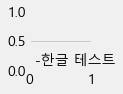

In [2]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import HuberRegressor

import re, copy

import geopandas as gpd
import folium

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
plt.style.use('fivethirtyeight')

# matplotlib 한글폰트 세팅
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

print('>>> 라이브러리 버전 :')
print(f'pandas : {pd.__version__}\t\t numpy : {np.__version__}\t\t sklearn : {sklearn.__version__}  |  \n' +\
      f'geopandas : {gpd.__version__}\t folium : {folium.__version__}\t matplotlib : {mpl.__version__}  |  \n' +\
      f'seaborn : {sns.__version__}')


plt.rc('font', family='malgun gothic')
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(1, 1))
plt.text(0.1, 0.1, '-한글 테스트')
plt.show()


# 데이터 메모리 축소 함수
def reduce_mem_usage(input_df, verbose=False):
    df = input_df.copy()

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


# 코로나19 확진자 데이터 전처리 함수
def covid_preprocessing(df):
  df['date'] = pd.to_datetime(df['date'])
  df['confirmed_D-1'] = [0] + df['confirmed'].iloc[:-1].tolist()
  df['confirmed_new'] = df['confirmed'] - df['confirmed_D-1']

  pre_weeks_df = pd.DataFrame(pd.date_range(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-01-19')),
                              columns=['date'])
  df = pd.merge(pre_weeks_df, df, 'outer', 'date').fillna(0)

  df['month'] = df['date'].dt.month
  df['weekofyear'] = df['date'].dt.weekofyear
  df = df.groupby(['month', 'weekofyear'])['confirmed_new'].sum().reset_index().astype(int)
  return df


# 코로나19 확진자 데이터 시각화 함수
def plot_covid(df, time_bin='weekofyear', show_pandemic_week=True):
  col='confirmed_new'
  tmp_df = df.groupby(time_bin)[col].sum().reset_index()
  tmp_df[time_bin] = tmp_df[time_bin].apply(lambda x:f'{time_bin}_{x}')

  plt.figure(figsize=(18, 6))
  pal = sns.color_palette("Reds_d", tmp_df.shape[0])
  rank = tmp_df[col].argsort().argsort()
  sns.barplot(data=tmp_df, x=time_bin, y=col, palette=np.array(pal[::-1])[rank])
  if time_bin=='weekofyear' and show_pandemic_week:
    plt.axvline(7.5, color='red')
    plt.axvline(13.5, color='red')
    plt.axvspan(7.5, 13.5, facecolor='red', alpha=0.1, label='코로나19 대확산 시기')
    plt.legend(fontsize=15)
  
  region_kor = '전국'
  time_bin_kor = '주차별' if time_bin=='weekofyear' else '월별'
  title = f'{region_kor} {time_bin_kor} 신규 확진자 수'
  plt.title(title, size=20)
  plt.xticks(rotation=45, size=15, ha='right') if time_bin=='weekofyear' else  plt.xticks(size=15)
  plt.xlabel(time_bin_kor, size=15)
  plt.ylabel(col, size=15)
  plt.show()
  return


# 특정 집단감염 사례 정보 출력 함수
def show_infection_case(case='Shincheonji Church'):
  info_df = big_case_df[(big_case_df.infection_case==case) & (big_case_df.city!='타도시')]
  print(f'사례 : {case_kor_dict[case]} (발생지역 : {info_df["province"].iloc[0]}, {info_df["city"].iloc[0]})')
  tmp_df = sido_infection_by_case[case]
  tmp_df = tmp_df[(tmp_df>0) & (tmp_df.index!='All')]
  display(tmp_df.sort_values(ascending=False).to_frame().T)


# 기간별 전국 교통량 합산 및 시각화 함수
def plot_OD_traffic_by_time(df, by='year', y_col='TOTAL_TRFC_STF', date_col='OPRAT_DATE', title='연도별 합산 통행인원', figsize=(5, 5)):
  plt.rcParams.update({'font.size': 15})
  cols = list(set(['year', by]))

  tmp_df = df[[date_col, y_col]].copy()
  tmp_df['year'] = tmp_df[date_col].dt.year

  if by == 'year':
    pass
  elif by == 'month':
    tmp_df[by] = tmp_df[date_col].dt.month
  elif by == 'weekofyear':
    tmp_df[by] = tmp_df[date_col].dt.weekofyear
    tmp_df = tmp_df[tmp_df.weekofyear.isin(range(tmp_df.weekofyear.min()+1, tmp_df.weekofyear.max()))]  # 데이터 불완전한 첫주&마지막주 제외
    tmp_df['weekofyear'] = tmp_df['weekofyear'].apply(lambda x : f'0{x}주차'[-4:])
  elif by == 'dayofweek':
    tmp_df[by] = tmp_df[date_col].dt.dayofweek
    tmp_df['weekofyear'] = tmp_df[date_col].dt.weekofyear
    tmp_df = tmp_df[tmp_df.weekofyear.isin(range(tmp_df.weekofyear.min()+1, tmp_df.weekofyear.max()))]  # 데이터 불완전한 첫주&마지막주 제외
  
  tmp_df = tmp_df.groupby(cols)[y_col].sum().divide(1000000).reset_index()

  if by != 'year':
    display(tmp_df.pivot('year', by, y_col).round(2))
    print('\n')
  if by == 'dayofweek':
    dayofweek_list = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    tmp_df['dayofweek'] = tmp_df['dayofweek'].apply(lambda x : dayofweek_list[x])
  
  plt.figure(figsize=figsize)
  if by == 'year':
    sns.barplot(x='year', y=y_col, data=tmp_df)
    msg_height = plt.gca().get_ylim()[1] * 0.1
    for idx, val in enumerate(tmp_df[y_col]):
      plt.text(idx, val-msg_height, f'{val:.2f}', color='white', fontweight='bold', ha='center')
  else:
    sns.barplot(x=by, y=y_col, hue='year', data=tmp_df)
    msg_height = plt.gca().get_ylim()[1] * 0.05
    for idx, (trans19, trans20) in enumerate(zip(tmp_df.loc[tmp_df.year==2019, y_col], tmp_df.loc[tmp_df.year==2020, y_col])):
      plt.text(idx-0.2, msg_height, f'{trans19:.2f}', color='white', rotation=90, fontweight='bold', ha='center')
      plt.text(idx+0.2, msg_height, f'{trans20:.2f}', color='white', rotation=90, fontweight='bold', ha='center')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)

  plt.title(title)
  plt.ylabel('통행량 (백만 대)') if y_col=='가상OBU_ID_COUNT' else plt.ylabel('통행량 (백만 명)')
  plt.xlabel(None)
  plt.show()


# 특정 지역발/지역행 시도별 통행량 시각화 함수
def plot_traffic_by_sido(tmp_df, from_sido=None, to_sido=None, date_range=None, title=None, divide_num=1000):
  ycol = 'TOTAL_TRFC_STF' if 'TOTAL_TRFC_STF' in tmp_df.columns else 'TRFC_STF' if 'TRFC_STF' in tmp_df.columns else '가상OBU_ID_COUNT'
  date_col = 'OPRAT_DATE' if ycol in ['TOTAL_TRFC_STF', 'TRFC_STF'] else '기준일자'
  depart_col = '출발_시도명' if ycol in ['TOTAL_TRFC_STF', 'TRFC_STF'] else '출발_시도_NM'
  arrive_col = '도착_시도명' if ycol in ['TOTAL_TRFC_STF', 'TRFC_STF'] else '도착_시도_NM'

  if date_range is not None:
    tmp_df = tmp_df[(tmp_df[date_col] >= date_range[0]) & (tmp_df[date_col] <= date_range[1])]

  if from_sido is not None:
    tmp_df = tmp_df[(tmp_df[depart_col]==from_sido) & (tmp_df[arrive_col]!=from_sido)]\
                .groupby(arrive_col)[ycol].sum()
  elif to_sido is not None:
    tmp_df = tmp_df[(tmp_df[arrive_col]==to_sido) & (tmp_df[depart_col]!=to_sido)]\
                .groupby(depart_col)[ycol].sum()
  else:
    raise Exception('출발 시도 또는 도착 시도를 입력해 주세요')
  
  tmp_df = tmp_df.sort_values(ascending=False).divide(divide_num)

  tmp_df.plot.bar(figsize=(15, 6), title=title)
  plt.xticks(rotation=45, ha='center')
  plt.show()

  return tmp_df


# 시도별 통행량 GeoDataFrame 생성/전처리 함수
def merge_gdf(main_gdf, value_df, left_on='CTP_KOR_NM', right_on='도착_시도명', divide_num=1):

  if type(value_df) == pd.Series:
    value_df = value_df.reset_index()
  value_col = [col for col in value_df.columns if col != right_on][0]

  tmp_gdf = main_gdf.copy()
  tmp_gdf = tmp_gdf.merge(value_df, how='left', left_on=left_on, right_on=right_on)
  tmp_gdf[value_col] = tmp_gdf[value_col].divide(divide_num)
  
  # tooltip 생성
  tmp_gdf['통행량 정보'] = tmp_gdf.apply( lambda row : f"<strong>{row[left_on]}</strong><br>" +\
                                                        f"지역 간 연결성 : {row[value_col]:.2f}",
                                          axis=1 )  
  return tmp_gdf


# 시도별 통행량 지도 시각화 함수 - 코랩에서 런타임 연결 끊어짐
def plot_choropleth_by_sido(gdf, value_col, sido_col='CTP_KOR_NM'):
    region = tmp_gdf.loc[(tmp_gdf[value_col].isna()) & (tmp_gdf[sido_col]!='제주특별자치도'), sido_col].iloc[0]
    map_name = f'2020년 1~5월 시도별 {region} 출발 통행량 지도'

    m = folium.Map(location=[36, 127], tiles="Stamen Toner", zoom_start=7)

    choropleth = folium.Choropleth(
      geo_data=gdf, data=gdf[[sido_col, value_col]], columns=[sido_col, value_col],
      name=map_name, legend_name = '통행량',
      key_on=f'feature.properties.{sido_col}', fill_color='Oranges', fill_opacity=0.95, 
      line_opacity=1, line_color='white', line_weight=2,color = 'gray',
    ).add_to(m)
    folium.LayerControl().add_to(m)
    choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['통행량 정보']))

    return map_name, m


# 주차별 통행량 추출 함수
def get_weekly_traffic(df, y_col='TOTAL_TRFC_STF', date_col='OPRAT_DATE', only2020=True):
  tmp_df = df[[date_col, y_col]].copy()
  tmp_df['year'] = tmp_df[date_col].dt.year
  tmp_df['weekofyear'] = tmp_df[date_col].dt.weekofyear
  tmp_df = tmp_df[tmp_df.weekofyear.isin(range(tmp_df.weekofyear.min()+1, tmp_df.weekofyear.max()))]  # 데이터 불완전한 첫주&마지막주 제외
  tmp_df['weekofyear'] = tmp_df['weekofyear'].apply(lambda x : f'0{x}주차'[-4:])
  tmp_df = tmp_df.groupby(['year', 'weekofyear'])[y_col].sum().divide(1000000).reset_index()

  if only2020:
    tmp_df = tmp_df[tmp_df.year==2020].drop(columns='year').reset_index(drop=True)

  return tmp_df

## 사용 데이터
(노트북 실행 시 메모리 문제로 인해, 전처리 후 parquet 포맷으로 압축한 데이터를 불러와 실행함)
- 날짜별 코로나19 확진자 수 통계 데이터 (Time.csv)
- 코로나19 감염사례 데이터 (Case.csv)
- 지역코드 데이터 (DD_AREA.dat)
- 전국 시/도 경계 데이터 (외부 데이터)
- 교통카드빅데이터 중 발권 OD 데이터 (DM_OD_NTSS_T.dat)
- 교통카드빅데이터 중 교통카드 OD 데이터 (DM_OD_TRCRD_T.dat)
- 한국도로공사 DSRC 데이터 (DSRC_DSRC\_ORIGIN\_*.csv)

In [3]:
data_dir = 'data/'

# 날짜별 전국 코로나19 확진자 수 데이터
covid_df = pd.read_csv(data_dir + 'COVID_19/Time.csv', usecols=['date', 'confirmed'])
covid_df = covid_preprocessing(covid_df)

# 집단감염 사례 정보 데이터
case_df = pd.read_csv(data_dir + 'COVID_19/Case.csv')

# 지역코드 데이터
dd_area_df = pd.read_csv(data_dir + 'DD_AREA.dat', sep='|', header=None)
dd_area_df.columns = ['area_cd', 'sido_cd', 'sgg_cd', 'use_area_cd', 'sido_nm', 'sgg_nm', 'emd_nm']
sido_dict = dict(dd_area_df[['sido_cd', 'sido_nm']].drop_duplicates().values)
sgg_dict = dict(dd_area_df[['sgg_cd', 'sgg_nm']].drop_duplicates().values)

# 전국 시/도 경계 데이터
district_geo_df = gpd.read_file(data_dir + 'sido_CTPRVN_202005/CTPRVN.shp', encoding='cp949')
district_geo_df['CTPRVN_CD'] = district_geo_df['CTPRVN_CD'].astype(int)

# 전처리된 발권 OD 데이터
ticket_df = pd.read_parquet(data_dir + 'DM_OD_NTSS_T.parquet', columns=['YYYYMM', 'OPRAT_DATE', 'STG_SD_CD', 'ARR_SD_CD', 'RLRD_TRFC_STF', 'ITCBUS_TRFC_STF', 'EXPBUS_TRFC_STF'])
ticket_df = ticket_df[~(ticket_df.STG_SD_CD.isin(['~','99'])) & ~(ticket_df.ARR_SD_CD.isin(['~','99']))]  # 이상치 제거
ticket_df = ticket_df.astype(int)
ticket_df = reduce_mem_usage(ticket_df.groupby(['YYYYMM', 'OPRAT_DATE', 'STG_SD_CD', 'ARR_SD_CD']).sum().reset_index())
ticket_df['OPRAT_DATE'] = pd.to_datetime(ticket_df['OPRAT_DATE'], format='%Y%m%d')
ticket_df['TOTAL_TRFC_STF'] = ticket_df[['RLRD_TRFC_STF', 'ITCBUS_TRFC_STF', 'EXPBUS_TRFC_STF']].sum(axis=1)
ticket_df['출발_시도명'] = ticket_df['STG_SD_CD'].apply(lambda x : sido_dict[int(x)])
ticket_df['도착_시도명'] = ticket_df['ARR_SD_CD'].apply(lambda x : sido_dict[int(x)])

# 전처리된 교통카드 OD 데이터
card_df = pd.read_parquet(data_dir + 'DM_OD_TRCRD_T_sam_200818.parquet', columns=['OPRAT_DATE', 'STG_SD_CD', 'ARR_SD_CD', 'TRFC_STF'])
card_df = card_df.groupby(['OPRAT_DATE', 'STG_SD_CD', 'ARR_SD_CD'])['TRFC_STF'].sum().reset_index()
card_df = reduce_mem_usage(card_df)
card_df['OPRAT_DATE'] = pd.to_datetime(card_df['OPRAT_DATE'], format='%Y%m%d')
card_df['출발_시도명'] = card_df['STG_SD_CD'].apply(lambda x : sido_dict[int(x)])
card_df['도착_시도명'] = card_df['ARR_SD_CD'].apply(lambda x : sido_dict[int(x)])

## 전처리된 DSRC 데이터
dsrc_df = pd.read_parquet(data_dir + 'DSRC_기준일자별_출발도착_지역별_가상OBUID_sum.parquet')
dsrc_df['가상OBU_ID_COUNT'] = dsrc_df['가상OBU_ID_COUNT'].astype(int)
dsrc_df['기준일자'] = pd.to_datetime(dsrc_df['기준일자'])

## 1. 코로나19 데이터 분석 - 시기별 전국 코로나19 확진자 수
- 날짜별 누적 확진자 데이터를 전처리하여, 날짜별 신규 확진자 수를 추출
- **월별 및 주차별 신규 확진자 수**를 시각화하여, 기간별 확진자 발생 추이를 확인
- 시간범위 : 2020년 1~6월 (6개월 간)

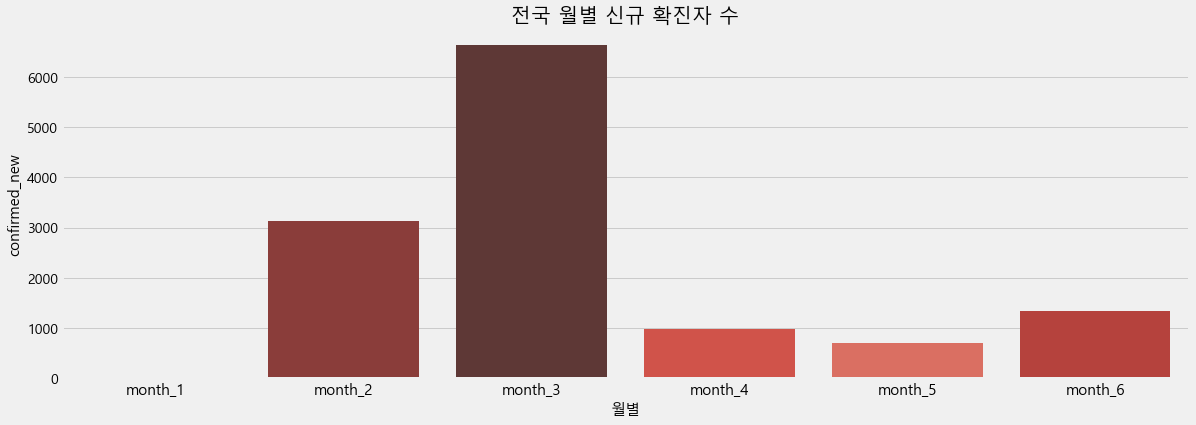

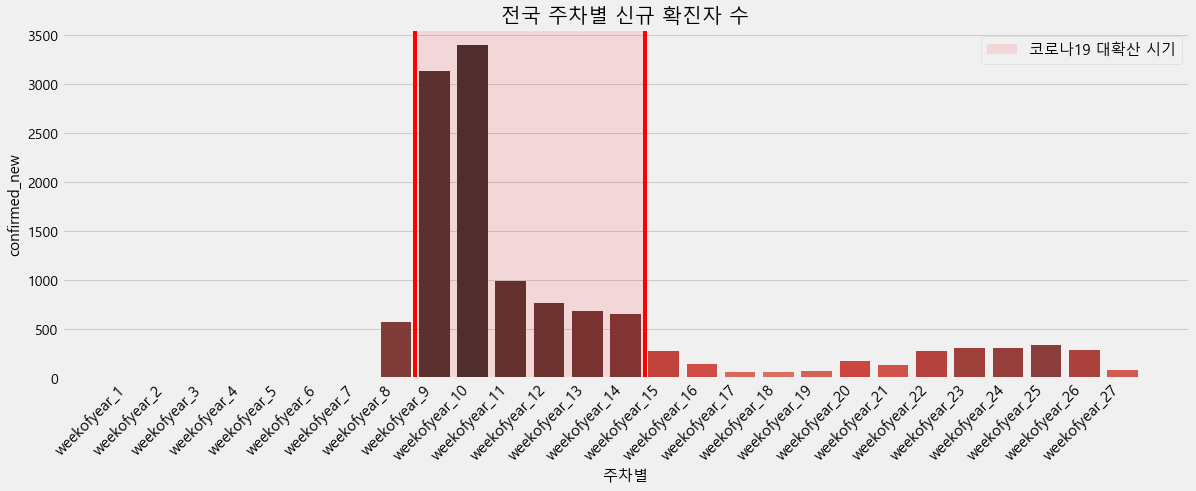

In [4]:
# 전국 확진자 추이
plot_covid(covid_df, time_bin='month')
print()
plot_covid(covid_df, time_bin='weekofyear')

- **시기별 분석**을 위해 월별, 주차별 확진자 추이를 살펴봄
- **월별** 코로나19 신규 확진자 수를 살펴볼 때, 신천지 집단감염 사태가 있었던 **2\~3월 신규 확진자 수가 만 명을 육박**하는 가장 많은 비중을 차지했으며, 이태원 클럽 및 리치웨이 집단감염 사태 등 서울시에서 일어난 집단감염 사태들로 인해 **5~6월에도 1300명 이상의 높은 수치**를 기록함
- **주차별** 코로나19 신규 확진자 수를 살펴볼 때, 신천지 집단감염 사태로 인해 **8주차에서 14주차 사이(7주 간)에 가장 높은 수치**를 기록함. 또한 이태원 집단감염 사태가 있었던 **19주차 이후에도 다시 증가 추세**를 보임
<br><br>

## 2. 코로나19 데이터 분석 - 지역별 감염사례
- 각 지역별로 코로나19 감염사례별 확진자 수를 제공하는 데이터
- 감염사례 중 **'지역 간 전파'가 일어난 집단감염 사례만 추출**
<br>
(지역 간 전파 : 특정 감염사례로 인해 3개 이상 시/도에서 관련 확진자 발생)
- 시간범위 : 2020년 1~6월 (6개월 간)

In [5]:
# 감염사례 수 확인
print('>>> 감염 사례 수 :', case_df.infection_case.nunique())
print('>>> 집단감염 사례 수 :', case_df[case_df.group].infection_case.nunique())
print(f'>>> 비집단감염 사례({case_df[~case_df.group].infection_case.nunique()}) : {case_df[~case_df.group].infection_case.unique()}')
print(f'>>> 집단감염 사례 확진자 비중 : {case_df[case_df.group].confirmed.sum()/case_df.confirmed.sum()*100:.2f}%')

# 누락 확진자 수 확인
tmp_df = pd.read_csv(data_dir + 'COVID_19/Time.csv')
confirm_num = tmp_df.loc[tmp_df.date=='2020-06-30', 'confirmed'].iloc[0]
print('\n>>> 6월 30일 기준 실제 누적 확진자 수  :', confirm_num)
print(f'>>> Case.csv 제공 확진자 수 : {case_df.confirmed.sum()} ({case_df.confirmed.sum()/confirm_num*100:.2f}%)')

>>> 감염 사례 수 : 81
>>> 집단감염 사례 수 : 78
>>> 비집단감염 사례(3) : ['overseas inflow' 'contact with patient' 'etc']
>>> 집단감염 사례 확진자 비중 : 68.90%

>>> 6월 30일 기준 실제 누적 확진자 수  : 12800
>>> Case.csv 제공 확진자 수 : 11395 (89.02%)


In [6]:
# 집단감염 사례 중 '지역 간 전파(3개 이상 시/도에서 관련 확진자 발생)' 사례만 추출 (8개 사례)
big_case_list = case_df[case_df.group].infection_case.value_counts()
big_case_list = big_case_list[big_case_list>=3].index.tolist()
big_case_df = case_df[case_df.infection_case.isin(big_case_list)]

# '지역 간 전파'가 일어난 집단감염 사례들의 지역별 확진자 수 시각화
sido_infection_by_case = pd.crosstab(index=big_case_df.infection_case, columns=big_case_df.province,
                                     values=big_case_df.confirmed, aggfunc=sum, margins=True)\
                              .fillna(0).astype(int)\
                              .sort_values('All', ascending=False).T.sort_values('All', ascending=False)

print(f'>>> 지역 간 전파가 일어난 집단감염 사례 : {sido_infection_by_case.shape[1]-1}개 \n')
case_kor_dict = {key:val for key, val \
                 in zip(sido_infection_by_case.columns,
                        ['합계', '신천지', '이태원클럽', '리치웨이', '구로구 콜센터', '쿠팡 물류센터', '청도대남병원', '대전 방문판매 업체', '금천구 육류공장'])}
tmp_df = sido_infection_by_case.copy()
tmp_df.columns = case_kor_dict.values()
tmp_df.iloc[1:].style.background_gradient('Reds')

>>> 지역 간 전파가 일어난 집단감염 사례 : 8개 



,합계,신천지,이태원클럽,리치웨이,구로구 콜센터,쿠팡 물류센터,청도대남병원,대전 방문판매 업체,금천구 육류공장
province,,,,,,,,,
대구,4515,4511,2,0,0,0,2,0,0
경상북도,685,566,0,0,0,0,119,0,0
서울,392,8,139,119,95,25,0,0,6
경기도,269,29,59,58,50,67,0,0,6
인천,117,2,53,0,20,42,0,0,0
대전,57,2,0,0,0,0,0,55,0
경상남도,34,32,2,0,0,0,0,0,0
강원도,25,17,0,4,0,0,0,0,4
부산,17,12,4,0,0,0,1,0,0


- **지역별 분석**을 위해, 감염 **사례 중 지역 간 전파가 일어난 집단감염 사례**들을 살펴봄
- 지역 간 전파(3개 이상 시/도에서 관련 확진자 발생)가 일어난 집단감염 사례는 총 8개로 확인됨
- 해당 집단감염 사례들의 확진자 분포는 대구-경북 지역, 수도권(서울/경기/인천) 지역, 충청권(대전/충북/충남) 등의 순으로 높게 분포함
- **각 집단감염 사례의 지역별 환자 분포는 대체로 생활권이 겹치는 곳에 집중**되는 것으로 파악됨 (ex. 수도권에 속하는 서울/경기/인천 지역 중 한 곳에서 집단감염이 발생하면, 수도권 전체 지역에 확진자 집중)

In [7]:
# 집단감염 사례별 확인
for case in sido_infection_by_case.columns:
  if case!='All':
    show_infection_case(case)

사례 : 신천지 (발생지역 : 대구, 남구)


province,대구,경상북도,경상남도,경기도,강원도,울산,부산,광주,서울,충청북도,대전,인천,세종,전라남도,전라북도
Shincheonji Church,4511,566,32,29,17,16,12,9,8,6,2,2,1,1,1


사례 : 이태원클럽 (발생지역 : 서울, 용산구)


province,서울,경기도,인천,충청북도,부산,전라북도,경상남도,대구,제주도
Itaewon Clubs,139,59,53,9,4,2,2,2,1


사례 : 리치웨이 (발생지역 : 서울, 관악구)


province,서울,경기도,강원도,충청남도
Richway,119,58,4,3


사례 : 구로구 콜센터 (발생지역 : 서울, 구로구)


province,서울,경기도,인천,충청북도
Guro-gu Call Center,95,50,20,2


사례 : 쿠팡 물류센터 (발생지역 : 경기도, 부천시)


province,경기도,인천,서울
Coupang Logistics Center,67,42,25


사례 : 청도대남병원 (발생지역 : 경상북도, 청도)


province,경상북도,대구,부산
Cheongdo Daenam Hospital,119,2,1


사례 : 대전 방문판매 업체 (발생지역 : 대전, -)


province,대전,충청남도,전라북도
Door-to-door sales in Daejeon,55,10,3


사례 : 금천구 육류공장 (발생지역 : 서울, 금천구)


province,경기도,서울,강원도
Geumcheon-gu rice milling machine manufacture,6,6,4


- **8개 집단감염 사례의 발원지는 대구, 서울, 경기, 경북, 대전**에 속함
- 앞서 확인한 바와 같이, 대체로 **한 지역에서 집단감염이 발생했을 때 생활권이 겹치는 지역으로 더 쉽게 전파**되는 모습임 (ex. 서울에서 집단감염 발생시 함께 수도권에 속하는 경기/인천 지역으로 전파)
<br><br>

<img src="https://icon-library.net/images/insight-icon/insight-icon-27.jpg" height="200"/>
 
### 코로나19 데이터 분석 - 소결론
- 시기별로 보았을 때, 신천지 집단감염 사태가 발생했던 **8주차\~14주차**(2\~3월)와 이태원 집단감염 사태 등이 발생했던 **19주차 이후**(5~6월)에 **확진자가 집중적으로 발생**함
<br><br>
- 지역별로 보았을 때, **한 지역에서 집단감염이 발생하면 해당 지역과 생활권이 밀접한 지역에 우선적으로 전파**가 일어남
<br><br>

## 3. 발권 OD 데이터 분석
- **철도/시외버스/고속버스 통행인원을 출발-도착 지역별로 제공**하는 데이터
- 교통수단 특성상 주로 **장거리를 이동하는 교통량**을 반영하는 데이터로 추정됨
- 시간범위 : 2019년 1\~5월, 2020년 1\~5월 (10개월 간)

### 3-1. 시기별 분석 - 연도별/월별/주차별 합산 통행인원

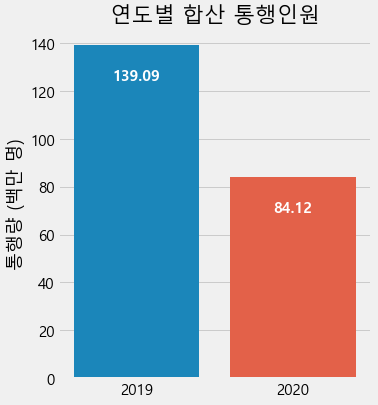

In [8]:
# 연도별 통행량 시각화
plot_OD_traffic_by_time(ticket_df, by='year', y_col='TOTAL_TRFC_STF', title='연도별 합산 통행인원', figsize=(5, 6))

- 발권 OD 데이터 상 2020년 1\~5월 합산 통행인원은 전년 동기 대비 약 40% 가까이 급격하게 하락함
- 2020년 상반기 코로나19의 대확산으로 인해 시/도간 장거리 통행량이 감소했으며, 아울러 시외버스/철도 등의 대중교통 사용을 기피하는 분위가 커진 탓으로 추정됨

month,1,2,3,4,5
year,,,,,
2019,26.66,28.21,27.95,26.64,29.63
2020,29.44,16.51,9.09,11.97,17.11


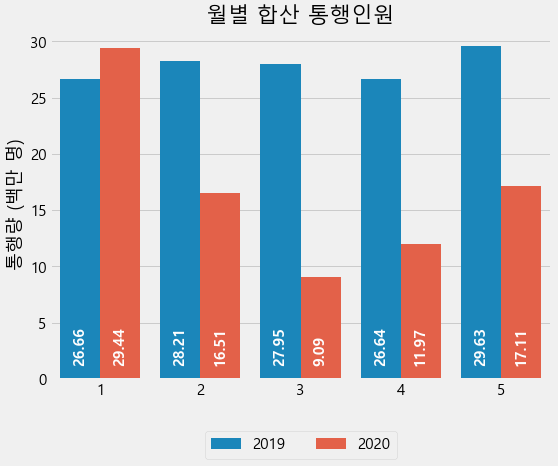

In [9]:
# 월별 통행량 시각화
plot_OD_traffic_by_time(ticket_df, by='month', y_col='TOTAL_TRFC_STF', title='월별 합산 통행인원', figsize=(8, 6))

- 월별로 2019년과 2020년을 비교해 볼 때, 1월의 통행인원은 약 29백만 명으로 전년 대비 10% 이상 증가했지만, 코로나19가 급속도로 확산되었던 2월부터 급감해 3월에는 9백만여 명으로 전년 대비 67% 이상 감소함
- 코로나19 확산세가 진정되면서, 2020년 3\~5월 사이 통행인원은 9백만 명에서 17백만 명으로 두 배 가까이 상승함. 그러나 돌이켜볼 때 이는 이후 이태원 집단감염 등 추가적인 지역 간 전파의 불씨가 되었음
- 이처럼 2020년 3\~5월 사이 통행인원이 급격히 증가하기는 했지만, 여전히 전년 동기 대비 절반 수준에 그침

weekofyear,02주차,03주차,04주차,05주차,06주차,07주차,08주차,09주차,10주차,11주차,12주차,13주차,14주차,15주차,16주차,17주차,18주차,19주차,20주차,21주차
year,,,,,,,,,,,,,,,,,,,,
2019,6.07,6.20,6.06,6.29,7.71,6.48,6.83,7.45,5.88,6.10,6.11,6.23,6.35,6.24,6.11,6.47,7.12,7.35,6.42,6.45
2020,6.14,6.15,8.06,5.98,4.40,4.84,3.98,1.97,1.79,2.04,2.18,2.24,2.34,2.48,2.73,2.96,4.03,3.95,3.66,3.74


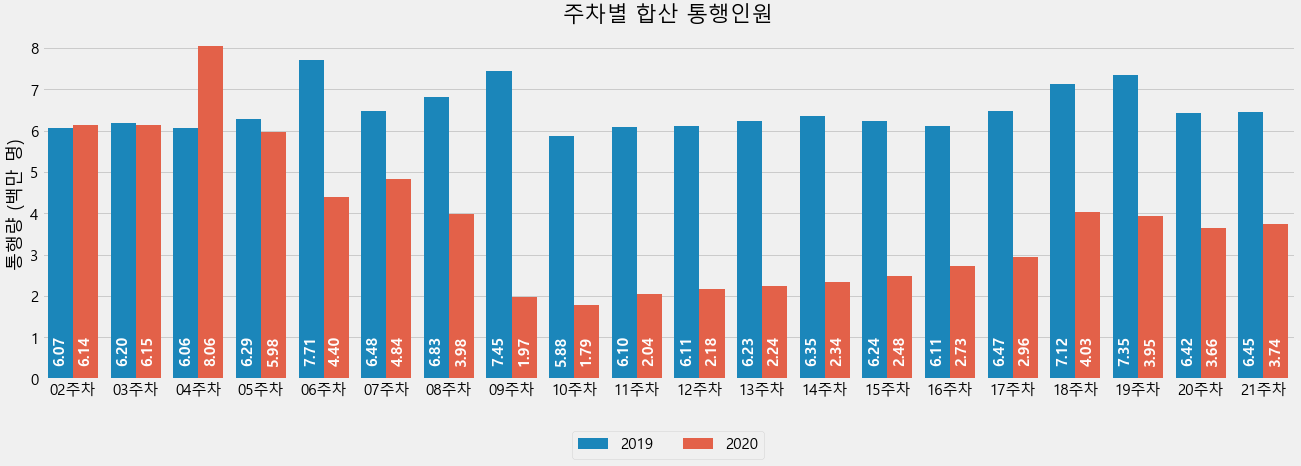

In [10]:
# 주차별 통행량 시각화
plot_OD_traffic_by_time(ticket_df, by='weekofyear', y_col='TOTAL_TRFC_STF', title='주차별 합산 통행인원', figsize=(20, 6))

- 주 단위로 살펴볼 때, 2019년의 경우 6주차 경, 2020년의 경우 4주차 경에 설(구정) 연휴로 인해 통행인원이 급증한 모습을 보임
- 이후 신천지 집단감염 사태로 인해 코로나19가 급속도로 퍼진 9주차(2월 24일 이후)에는 전년 대비 통행인원이 무려 74% 가까이 급감하였음
- 이후 코로나19 확산세가 위축되며 조금씩 증가하던 통행인원은 황금연휴가 포함된 18주차(4월 27일 이후)에 정점을 찍었다가 이태원 클럽 집단감염 사태 등으로 인해 다시 감소세에 접어듦
<br><br>

- 흥미로운 부분은, 전국적 대확산을 초래한 신천지 사태와 이태원 클럽 사태 등 **대규모 집단감염이 발생하기 직전 주에 통행량이 급증**했다는 사실임.
- **7주차**의 경우 주간 통행량이 약 4.84백만 명으로 **전주 대비 10% 가량 급증**했으며, **18주차**의 경우 주간 통행량이 약 4.03백만 명으로 **전주 대비 36% 가량 급증**했음
<br><br>

### 3-2. 지역별 분석 - 특정 시/도에서 전국 각 지역으로 이동한 통행량
- 발권 OD 데이터를 사용해 날짜별로 출발 시/도와 도착 시/도 통행량 합산을 구할 수 있음
- 앞서 코로나19 데이터 분석에서 '지역 간 전파'를 유발한 5개 시/도를 확인했음
- 해당 5개 시/도에서 전국 각 지역으로 이동한 통행량을 분석함으로써, **"지역 간 연결성"이 서로 높은 지역일수록 "지역 간 전파"가 쉽게 일어나는지 확인**할 수 있음

사례 : 신천지 (발생지역 : 대구, 남구)


province,대구,경상북도,경상남도,경기도,강원도,울산,부산,광주,서울,충청북도,대전,인천,세종,전라남도,전라북도
Shincheonji Church,4511,566,32,29,17,16,12,9,8,6,2,2,1,1,1


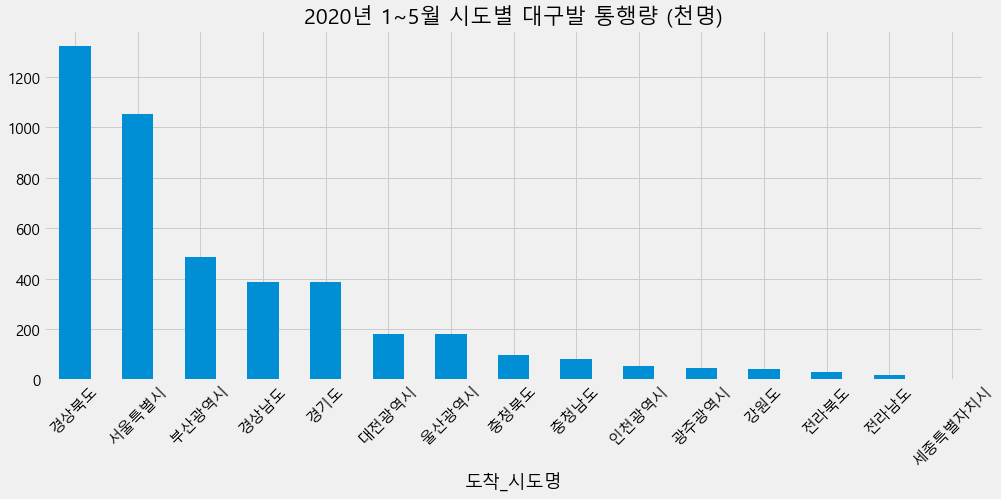

In [11]:
show_infection_case('Shincheonji Church')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(ticket_df, from_sido='대구광역시', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 대구발 통행량 (천명)', divide_num=1000)

- **대구에서 발생한 신천지 집단감염 사태는 경상남/북도와 경기도 지역으로 전파**가 높게 일어남
- 발권 OD 데이터에서 **대구발 통행량 상위 5위 안에 경상남/북도와 경기도가 모두 포함**됨. 다만 역시 상위 5위 안에 포함되어 있는 서울과 부산에서는 감염병 전파가 비교적 적게 일어남

사례 : 청도대남병원 (발생지역 : 경상북도, 청도)


province,경상북도,대구,부산
Cheongdo Daenam Hospital,119,2,1


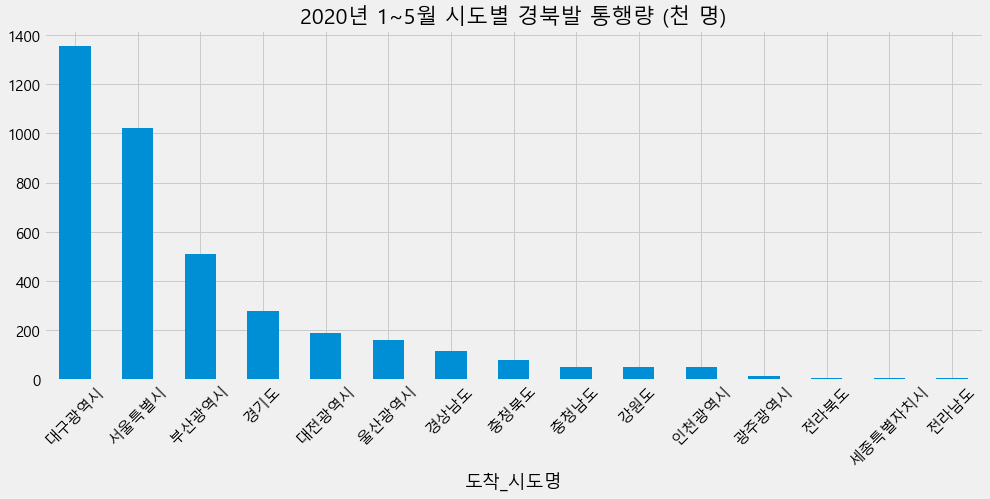

In [12]:
show_infection_case('Cheongdo Daenam Hospital')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(ticket_df, from_sido='경상북도', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 경북발 통행량 (천 명)', divide_num=1000)

- **경상북도에서 발생한 청도대남병원 집단감염 사태는 대구와 부산 지역으로 전파**가 높게 일어남
- 발권 OD 데이터에서 **경북발 통행량 상위 3위 안에 대구와 부산이 모두 포함**되어 있음. 다만 역시 높은 통행량을 기록한 서울에서는 관련 확진자가 발생하지 않았음.

사례 : 이태원클럽 (발생지역 : 서울, 용산구)


province,서울,경기도,인천,충청북도,부산,전라북도,경상남도,대구,제주도
Itaewon Clubs,139,59,53,9,4,2,2,2,1


사례 : 리치웨이 (발생지역 : 서울, 관악구)


province,서울,경기도,강원도,충청남도
Richway,119,58,4,3


사례 : 구로구 콜센터 (발생지역 : 서울, 구로구)


province,서울,경기도,인천,충청북도
Guro-gu Call Center,95,50,20,2


사례 : 금천구 육류공장 (발생지역 : 서울, 금천구)


province,경기도,서울,강원도
Geumcheon-gu rice milling machine manufacture,6,6,4


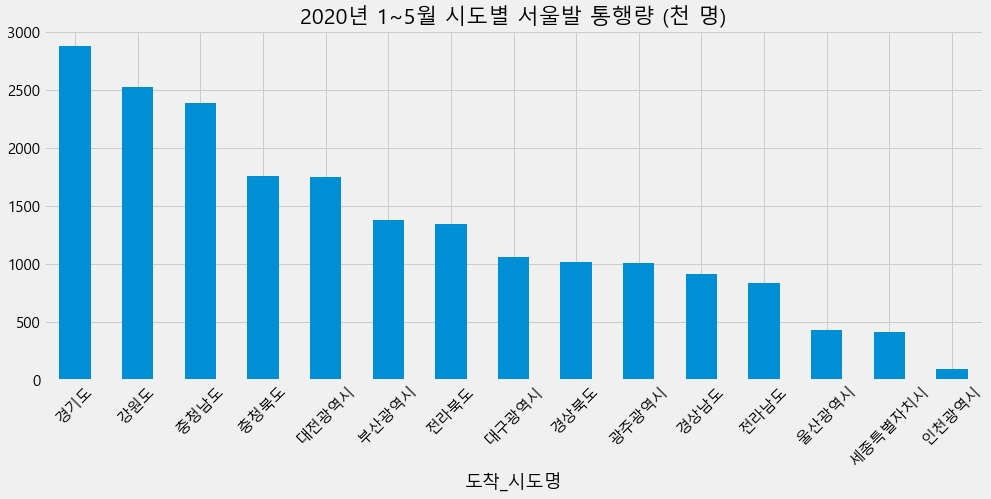

In [13]:
for case in ['Itaewon Clubs', 'Richway', 'Guro-gu Call Center', 'Geumcheon-gu rice milling machine manufacture']:
  show_infection_case(case)
print('\n')
tmp_traffic_df = plot_traffic_by_sido(ticket_df, from_sido='서울특별시', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 서울발 통행량 (천 명)', divide_num=1000)

- **서울에서 발생한 집단감염 사태들은 같은 수도권에 속하는 경기/인천 지역에 더해 충청권과 강원도로 전파**가 빈번하게 일어남
- 발권 OD 데이터에서 **서울발 통행량 상위 5위 안에 해당 지역들이 대부분 포함**되어 있음
<br><br>
- 인천의 경우 통행량이 매우 적게 나타나는데, 장거리 이동이 주로 반영된 발권 OD 데이터보다는 이후 분석할 교통카드 OD 데이터와 DSRC 데이터에서 통행량이 높게 나타남
- 대전의 경우에도 서울발 통행량이 높게 나타나는데, 집단감염 사례 중 "대전 방문판매 업체" 사례가 "서울 리치웨이" 사례로부터 전파된 사례임을 고려하면 이 역시 통행량과 관계가 있다고 추정할 수 있음  ([관련 뉴스기사 링크](https://biz.chosun.com/site/data/html_dir/2020/07/08/2020070801090.html))
<br><br>

사례 : 쿠팡 물류센터 (발생지역 : 경기도, 부천시)


province,경기도,인천,서울
Coupang Logistics Center,67,42,25


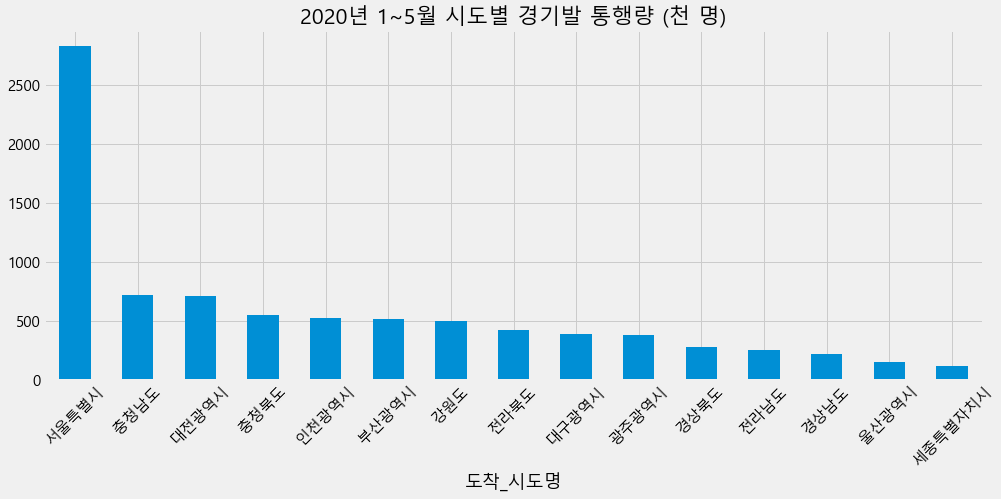

In [14]:
show_infection_case('Coupang Logistics Center')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(ticket_df, from_sido='경기도', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 경기발 통행량 (천 명)', divide_num=1000)

- **경기도에서 발생한 쿠팡 물류센터 집단감염 사태는 수도권 내에서 전파**가 높게 일어남
- 발권 OD 데이터에서 **경기발 통행량 상위 3위 안에 서울이 포함**되지만, 인천은 통행량이 낮게 나타남. 다만 장거리 이동이 주로 반영된 발권 OD 데이터보다는 이후 분석할 교통카드 OD 데이터와 DSRC 데이터에서 인천으로 향하는 통행량 역시 높게 나타남

사례 : 대전 방문판매 업체 (발생지역 : 대전, -)


province,대전,충청남도,전라북도
Door-to-door sales in Daejeon,55,10,3


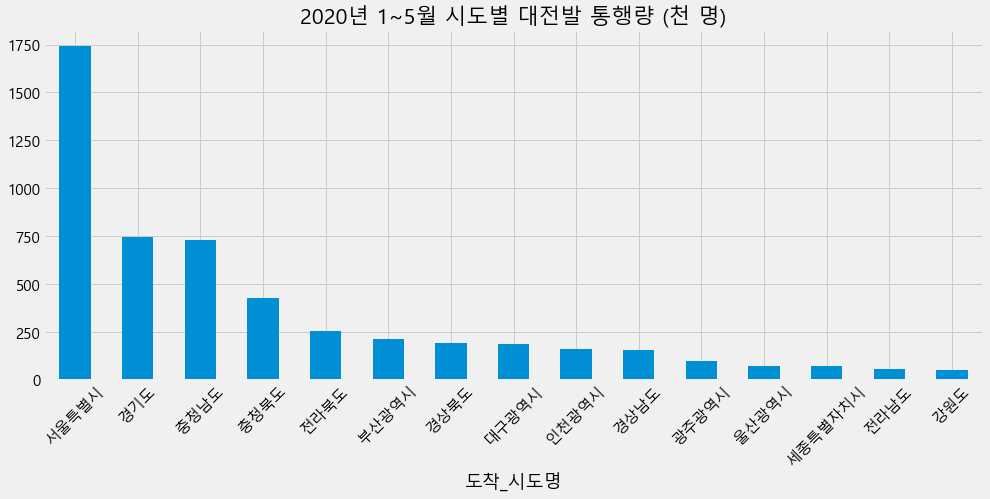

In [15]:
show_infection_case('Door-to-door sales in Daejeon')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(ticket_df, from_sido='대전광역시', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 대전발 통행량 (천 명)', divide_num=1000)

- **대전에서 발생한 방문판매 업체 집단감염 사태는 충청남도와 전라북도 지역으로 전파**가 높게 일어남
- 발권 OD 데이터에서 **대전발 통행량 상위 5위 안에 충청남도와 전라북도가 모두 포함**되어 있음.
- 대전발 통행량이 높게 나타난 **서울 및 경기 수도권 지역의 경우, 앞서 언급한 것처럼 방문판매 업체 확진자가 최초 유입된 지역**에 해당함. 따라서 역시 지역 간 통행량과 코로나19 지역 간 전파의 관계를 반영하는 대목이라고 할 수 있음
<br><br>

<img src="https://icon-library.net/images/insight-icon/insight-icon-27.jpg" height="200"/>
 
### 발권 OD 데이터 분석 - 소결론
- 시기별로 보았을 때, 전국적인 대규모 집단감염이 발생하기 직전인 7주차와 18주차에 전주 대비 통행량이 급증함. 이는 역으로 발하면 **전주 대비 통행량이 급증한 주간에 대규모 집단감염 발생 위험이 높아진**다는 사실을 의미함
<br><br>
- 지역별로 보았을 때, 특정 지역에서 집단감염이 발생하면 해당 지역과 교통 이동량이 높은 지역으로 지역 간 전파가 일어날 가능성이 높은 것으로 나타남. 이는 역으로 말하면 **한 지역에서 집단감염이 발생한 경우 해당 지역과 교통 이동량이 높은 지역에서 선제적으로 방역 대책을 세우는 것이 유효한 대응일 수 있다**는 사실을 의미함.
<br><br>

## 4. 교통카드 OD 데이터 분석
- **교통카드 사용 통행인원을 출발-도착 지역별로 제공**하는 데이터
- 교통수단 특성상 발권 OD 데이터에 비해 상대적으로 **단거리를 이동하는 교통량**을 반영하는 데이터로 추정됨
- 시간범위 : 2019년 1\~5월, 2020년 1\~5월 (10개월 간)

### 4-1. 시기별 분석 - 연도별/월별/주차별 합산 통행인원

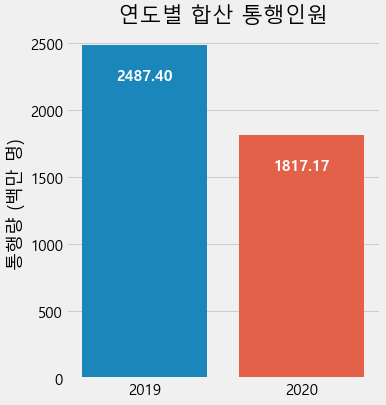

In [16]:
# 연도별 통행량 시각화
plot_OD_traffic_by_time(card_df, by='year', y_col='TRFC_STF', title='연도별 합산 통행인원', figsize=(5, 6))

- 2020년 1\~5월 합산 통행인원은 전년 동기 대비 약 27% 가까이 하락함
- 통행인원 감소가 적지 않지만, 약 40%로 대폭 감소한 발권 OD 데이터에 비해서는 적은 감소폭을 기록함
- 이는 교통카드 OD 데이터에 통근, 통학 등 일상적이고 필수적인 단거리 교통량이 많이 반영되었기 때문으로 추정됨

month,1,2,3,4,5
year,,,,,
2019,488.53,422.95,517.49,519.29,539.13
2020,455.14,370.48,300.76,324.66,366.14


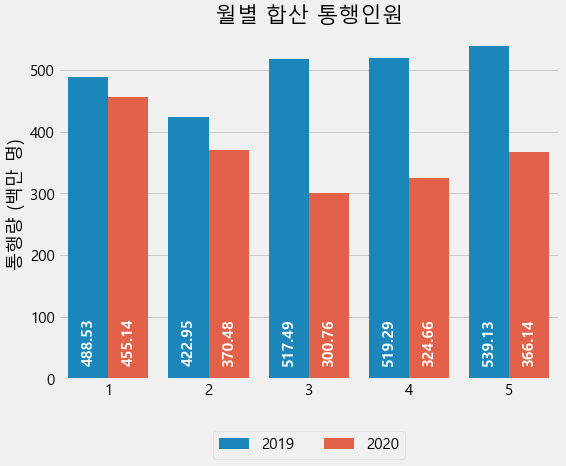

In [17]:
# 월별 통행량 시각화
plot_OD_traffic_by_time(card_df, by='month', y_col='TRFC_STF', title='월별 합산 통행인원', figsize=(8, 6))

- 월별 합산 통행인원 추이를 살펴보면, 2019년에는 방학 등으로 인해 1\~2월 통행인원이 감소했다가 개학시즌이 지나면서 대폭 증가하는 추세를 보임
- 반면 2020년에는 코로나19 대확산으로 인해 오프라인 등교가 연기 또는 취소되면서, 3월 통행인원이 기간 내 최저치를 기록함
- 코로나19 확산세가 진정되면서, 2020년 3\~5월 사이 통행인원은 300백만 명에서 366백만 명으로 전년보다 빠른 속도로 상승하는 추세임. 그러나 돌이켜볼 때 이는 이후 이태원 집단감염 등 추가적인 집단 감염의 불씨가 되었음

weekofyear,02주차,03주차,04주차,05주차,06주차,07주차,08주차,09주차,10주차,11주차,12주차,13주차,14주차,15주차,16주차,17주차,18주차,19주차,20주차,21주차
year,,,,,,,,,,,,,,,,,,,,
2019,111.51,111.01,112.15,108.48,79.69,115.76,116.12,110.38,120.34,120.21,119.58,119.84,120.65,120.17,119.91,120.74,120.43,117.74,121.96,123.15
2020,110.82,112.29,91.83,93.84,95.97,99.49,92.87,66.64,65.61,67.48,69.41,70.75,72.06,74.37,71.75,80.29,75.09,79.32,85.33,86.95


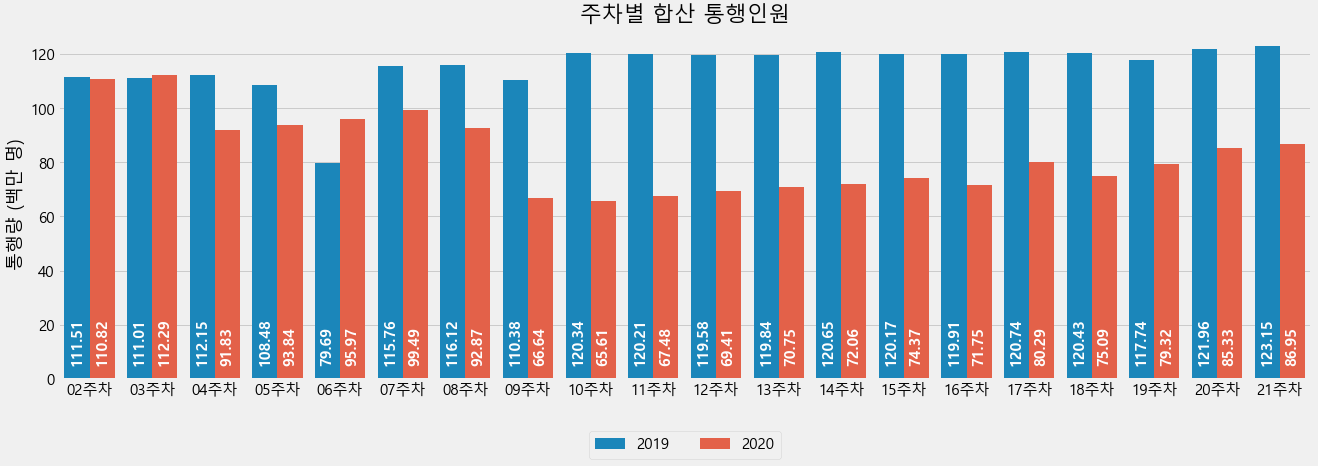

In [18]:
# 주차별 통행량 시각화
plot_OD_traffic_by_time(card_df, by='weekofyear', y_col='TRFC_STF', title='주차별 합산 통행인원', figsize=(20, 6))

- 주 단위로 살펴볼 때, 2019년의 경우 6주차 경, 2020년의 경우 4주차 경에 설(구정) 연휴로 인해 통행인원이 급감한 모습을 보임.
- 이는 해당 기간에 통행인원이 증가한 발권 OD 데이터와 상반되는 움직임으로, 연휴 기간에는 고향 방문 등 시/도간 장거리 이동이 증가하고 통근 등 시/도 내의 단거리 이동은 감소하기 때문인 것으로 판단됨
- 2019년에는 어린이날 대체휴일 등이 포함된 19주차(5월 6일 이후)에 통행 인원이 전주 대비 감소함. 마찬가지로, 2020년에도 증가 추세이던 통행 인원이 황금연휴가 포함된 18주차(4월 27일 이후)에 전주 대비 소폭 감소함
- 결국, 연휴기간 등 생활 패턴이 변하는 특수한 시기에 교통카드 이용 통행인원이 감소하는 반복적 패턴이 확인됨
<br><br>
- 발권 OD 데이터에서는 전국적인 대규모 집단감염이 발생하기 직전인 7주차와 18주차에 전주 대비 통행량이 급증했음. 그러나 교통카드 OD 데이터에서는 대규모 집단감염 발생시기 직전 특이한 동향이 발견되지는 않음.
<br><br>

### 4-2. 지역별 분석 - 특정 시/도에서 전국 각 지역으로 이동한 통행량

사례 : 신천지 (발생지역 : 대구, 남구)


province,대구,경상북도,경상남도,경기도,강원도,울산,부산,광주,서울,충청북도,대전,인천,세종,전라남도,전라북도
Shincheonji Church,4511,566,32,29,17,16,12,9,8,6,2,2,1,1,1


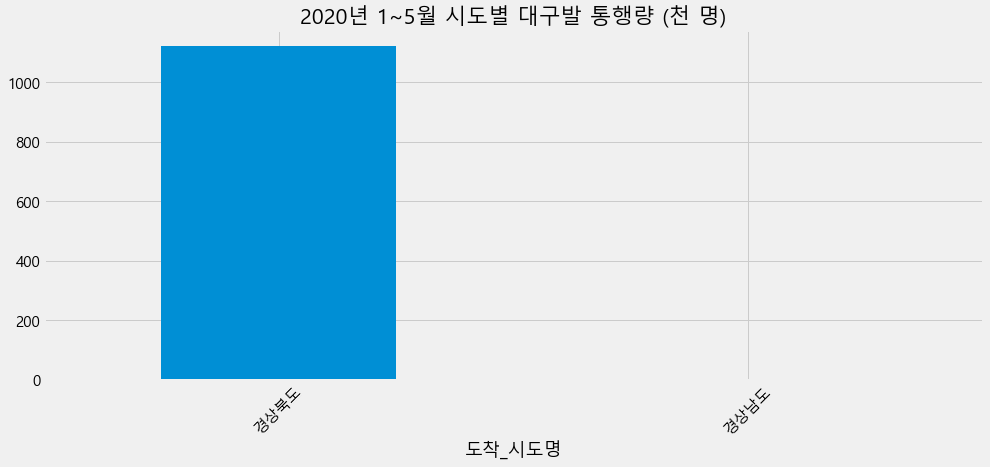

In [19]:
show_infection_case('Shincheonji Church')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(card_df, from_sido='대구광역시', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 대구발 통행량 (천 명)', divide_num=1000)

- **대구에서 발생한 신천지 집단감염 사태는 경상남/북도와 경기도 지역으로 전파**가 높게 일어남
- 교통카드 OD 데이터에서 **대구발 통행량은 경상남/북도에 집중**되어 있음. 주로 단거리 이동량이 반영된 데이터이기 때문에 경기도를 향한 교통량은 반영되지 않음


사례 : 청도대남병원 (발생지역 : 경상북도, 청도)


province,경상북도,대구,부산
Cheongdo Daenam Hospital,119,2,1


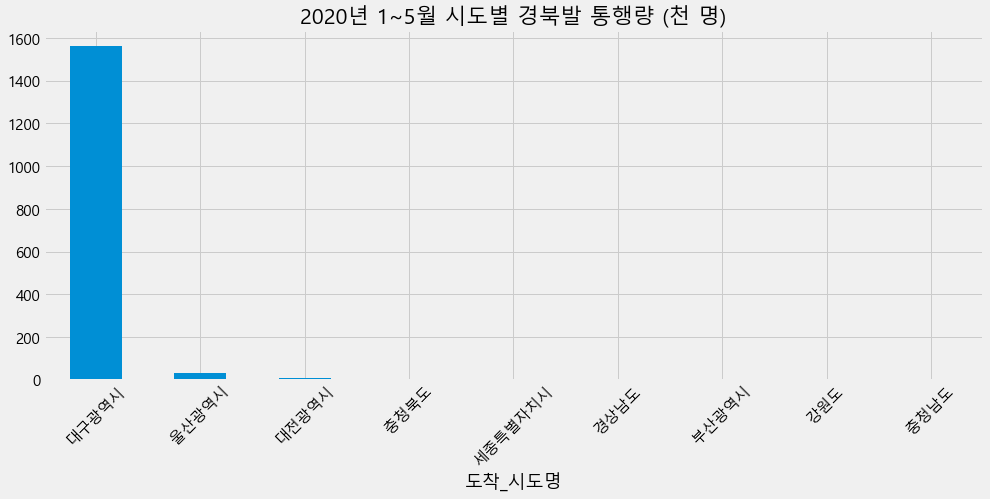

In [20]:
show_infection_case('Cheongdo Daenam Hospital')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(card_df, from_sido='경상북도', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 경북발 통행량 (천 명)', divide_num=1000)

- **경상북도에서 발생한 청도대남병원 집단감염 사태는 대구와 부산 지역으로 전파**가 일어남
- 교통카드 OD 데이터에서 **경북발 통행량은 압도적으로 대구 지역에 집중**되어 있음.


사례 : 이태원클럽 (발생지역 : 서울, 용산구)


province,서울,경기도,인천,충청북도,부산,전라북도,경상남도,대구,제주도
Itaewon Clubs,139,59,53,9,4,2,2,2,1


사례 : 리치웨이 (발생지역 : 서울, 관악구)


province,서울,경기도,강원도,충청남도
Richway,119,58,4,3


사례 : 구로구 콜센터 (발생지역 : 서울, 구로구)


province,서울,경기도,인천,충청북도
Guro-gu Call Center,95,50,20,2


사례 : 금천구 육류공장 (발생지역 : 서울, 금천구)


province,경기도,서울,강원도
Geumcheon-gu rice milling machine manufacture,6,6,4


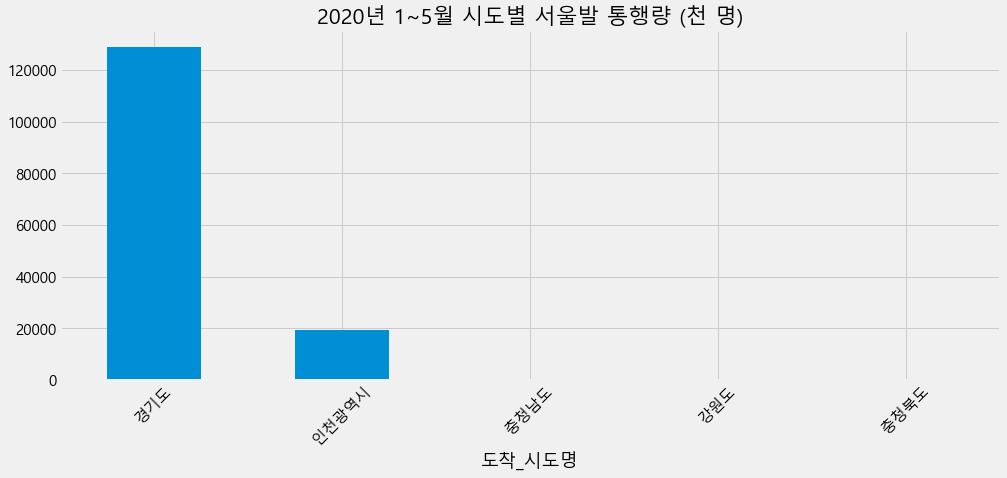

In [21]:
for case in ['Itaewon Clubs', 'Richway', 'Guro-gu Call Center', 'Geumcheon-gu rice milling machine manufacture']:
  show_infection_case(case)
print('\n')
tmp_traffic_df = plot_traffic_by_sido(card_df, from_sido='서울특별시', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 서울발 통행량 (천 명)', divide_num=1000)

- **서울에서 발생한 집단감염 사태들은 같은 수도권에 속하는 경기/인천 지역에 더해 충청권과 강원도로 전파**가 빈번하게 일어남
- 교통카드 OD 데이터에서 **서울발 통행량 상위 5위가 해당 지역과 일치**함

사례 : 쿠팡 물류센터 (발생지역 : 경기도, 부천시)


province,경기도,인천,서울
Coupang Logistics Center,67,42,25


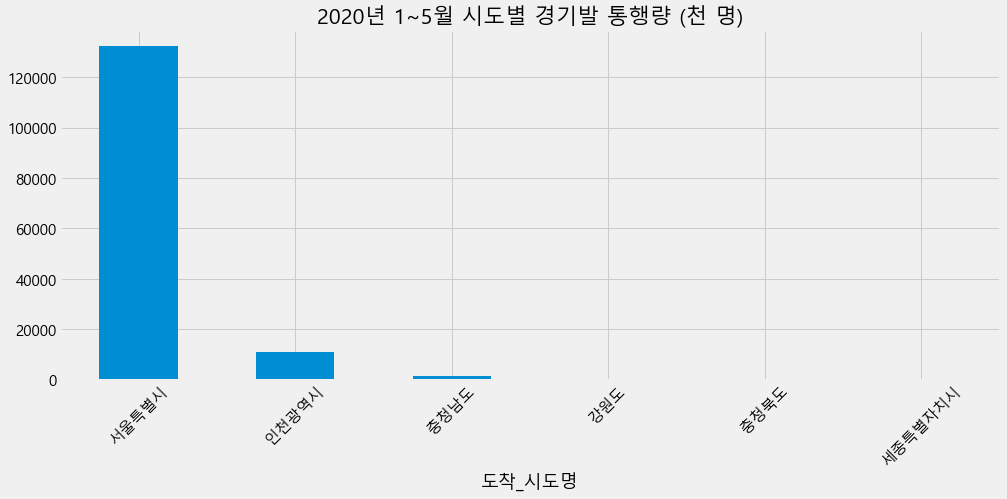

In [22]:
show_infection_case('Coupang Logistics Center')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(card_df, from_sido='경기도', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 경기발 통행량 (천 명)', divide_num=1000)

- **경기도에서 발생한 쿠팡 물류센터 집단감염 사태는 수도권 내에서 전파**가 집중됨
- 교통카드 OD 데이터에서 **경기발 통행량 상위 2개 도시가 서울과 인천으로 일치**함

사례 : 대전 방문판매 업체 (발생지역 : 대전, -)


province,대전,충청남도,전라북도
Door-to-door sales in Daejeon,55,10,3


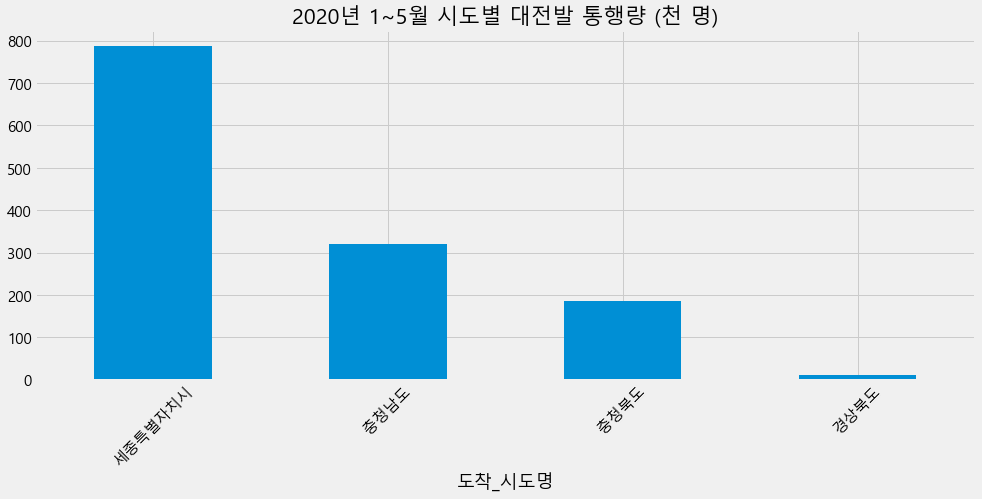

In [23]:
show_infection_case('Door-to-door sales in Daejeon')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(card_df, from_sido='대전광역시', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 대전발 통행량 (천 명)', divide_num=1000)

- **대전에서 발생한 방문판매 업체 집단감염 사태는 충청남도와 전라북도 지역으로 전파**가 높게 일어남
- 교통카드 OD 데이터에서 **대전발 통행량 상위 3위 안에 충청남북도가 포함**되어 있음. 다만 통행량이 가장 높게 나타난 세종시의 경우 관련 확진자가 발생하지는 않았음

<img src="https://icon-library.net/images/insight-icon/insight-icon-27.jpg" height="200"/>

### 교통카드 OD 데이터 분석 - 소결론
- 교통카드 데이터는 주로 단거리 이동 통행량이 반영된 데이터로 추정됨
- **통근, 통학 등 보다 일상적인 단거리 이동량이 높게 반영된 만큼, 발권 OD 데이터에 비해 코로나19 탄력성, 즉 코로나19로 인한 통행인원 변화량이 더 적은 것으로 나타남**
<br><br>
- 시기별 분석 및 지역별 분석 내용을 종합하여 볼 때, 교통카드 OD 데이터는 전국 단위의 코로나 대확산 선행지표로는 타당성이 다소 부족하다고 판단됨
- 다만 **수도권, 경상권과 같이 생활권이 밀접하고 거리가 가까운 지역들의 코로나 확산 선행지표로는 의미**가 있는 것으로 판단됨. 지역 간 코로나 전파 위험성을 판단할 때 발권 OD 데이터를 보완하는 용도로 적합해 보임
<br><br>

## 5. DSRC 데이터 분석
- 하이패스 차량단말기(OBU,RF형식)가 장착된 차량이 노변 기지국(RSE)을 통과할 때 수집된 데이터로,  차량의 경로 및 속도 등의 차량 통행패턴 정보 반영
- 날짜별로 각 차량(OBU_ID)의 첫 기록과 마지막 기록을 추출해 압축 저장한 데이터셋 사용 → **날짜별 각 차량의 출발 지역과 도착 지역 정보**
- 시간범위 : 2019년 1\~5월, 2020년 1\~5월 (10개월 간)

### 5-1. 시기별 분석 - 연도별/월별/주차별 합산 통행량

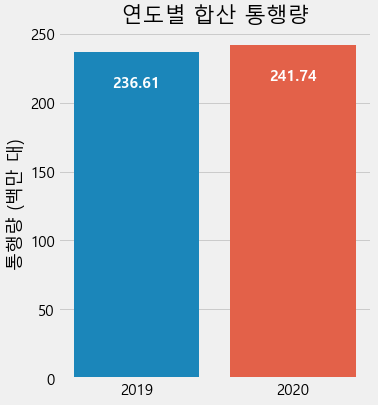

In [24]:
# 연도별 합산 통행량 시각화
plot_OD_traffic_by_time(dsrc_df, by='year', y_col='가상OBU_ID_COUNT', date_col='기준일자', title='연도별 합산 통행량', figsize=(5,6))

- 2019년 대비 2020년에 통행량이 2.2% 증가
- 발권 OD 데이터, 교통카드 OD 데이터와 같이 대중교통 수단과는 다르게 오히려 소폭 증가
- **코로나의 확산으로 인하여 다른 사람과의 접촉이 적은 차량의 이용이 증가한 것으로 추정**

month,1,2,3,4,5
year,,,,,
2019,46.06,43.53,48.47,48.24,50.31
2020,51.35,43.75,44.80,49.28,52.55


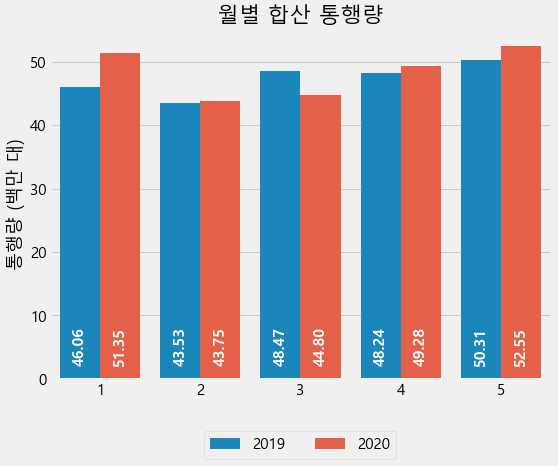

In [25]:
# 월별 합산 통행량 시각화
plot_OD_traffic_by_time(dsrc_df, by='month', y_col='가상OBU_ID_COUNT', date_col='기준일자', title='월별 합산 통행량', figsize=(8,6))

- 2020년 1월은 설날(구정) 때문에 작년에 비해 통행량이 약 11% 증가
- 반면 본격적으로 코로나 전파가 시작된 20년 2월 전월 대비 약 15% 감소
- 그럼에도 불구하고 전년 동월 비슷한 통행량을 기록함
- 이후 신천지, 이태원 클럽 등의 집단 감염이 발생함에도 불구하고 발권 OD 데이터, 교통카드 OD 데이터와는 달리 가파르게 증가
- 특히 20년 5월의 경우, 전년 동월 대비 약 4% 증가


[참고 기사]<br>
"차막힘 이유 있었다"...교통량, 코로나19 이전으로 복귀 -2020.7.13- <br>
http://www.insjournal.co.kr/news/articleView.html?idxno=2449

weekofyear,02주차,03주차,04주차,05주차,06주차,07주차,08주차,09주차,10주차,11주차,12주차,13주차,14주차,15주차,16주차,17주차,18주차,19주차,20주차,21주차
year,,,,,,,,,,,,,,,,,,,,
2019,10.37,10.51,10.51,10.56,11.36,10.55,10.70,11.17,10.55,10.89,10.94,11.22,11.48,11.20,11.25,11.17,11.87,11.64,11.01,11.25
2020,11.05,11.26,13.21,10.74,10.83,11.08,10.47,9.57,10.05,10.40,10.80,10.92,9.69,11.26,11.21,11.58,12.61,11.82,11.56,11.72


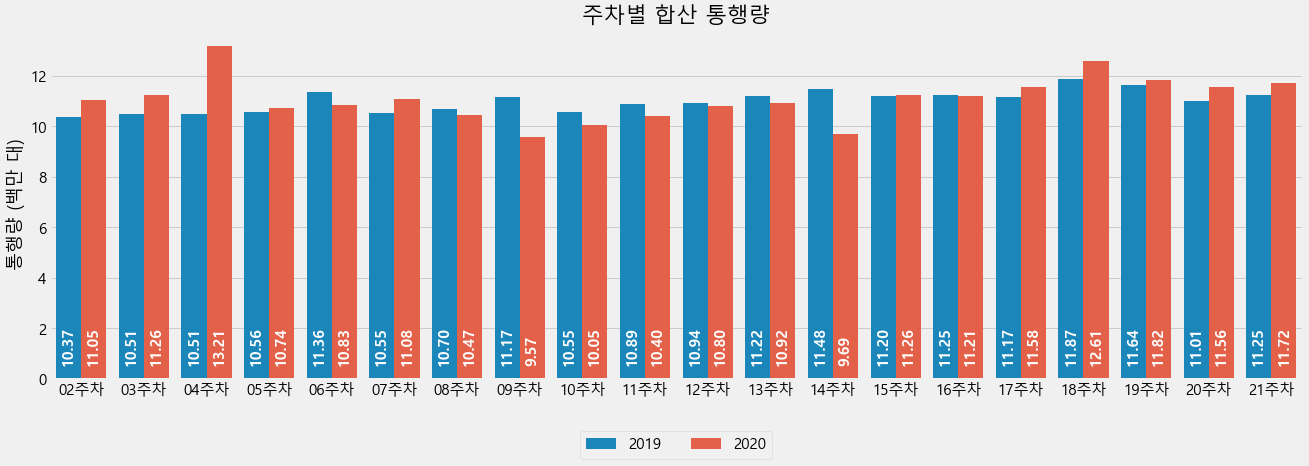

In [26]:
# 주차별 합산 통행량 시각화
plot_OD_traffic_by_time(dsrc_df, by='weekofyear', y_col='가상OBU_ID_COUNT', date_col='기준일자', title='주차별 합산 통행량', figsize=(20,6))

- DSRC 데이터의 주차별 통행량은 앞서 발권 OD 데이터의 주차별 통행인원과 유사도가 높음
<br><br>
- 주 단위로 살펴볼 때, 2019년의 경우 6주차 경, 2020년의 경우 4주차 경에 설(구정) 연휴로 인해 통행인원이 급증함
- 이후 신천지 집단감염 사태로 인해 코로나19가 급속도로 퍼진 9주차(2월 24일 이후)에는 전년 대비 통행인원이 급격히 감소함
- 이후 코로나19 확산세가 위축되며 조금씩 증가하던 통행인원은 황금연휴가 포함된 18주차(4월 27일 이후)에 정점을 찍었다가 이태원 클럽 집단감염 사태 등으로 인해 다시 감소세에 접어듦
<br><br>

- 발권 OD 데이터와 유사하게, 전국적 대확산을 초래한 신천지 사태와 이태원 클럽 사태 등 **대규모 집단감염이 발생하기 직전 주에 통행량이 증가**했음.
- **7주차**의 경우 주간 통행량이 약 11.08백만 대로 **전주 대비 2.3% 가량 증가**했으며, **18주차**의 경우 주간 통행량이 약 12.61백만 명으로 **전주 대비 약 9% 증가**했음
<br><br>

### 5-2. 지역별 분석 - 특정 시/도에서 전국 각 지역으로 이동한 통행량

사례 : 신천지 (발생지역 : 대구, 남구)


province,대구,경상북도,경상남도,경기도,강원도,울산,부산,광주,서울,충청북도,대전,인천,세종,전라남도,전라북도
Shincheonji Church,4511,566,32,29,17,16,12,9,8,6,2,2,1,1,1


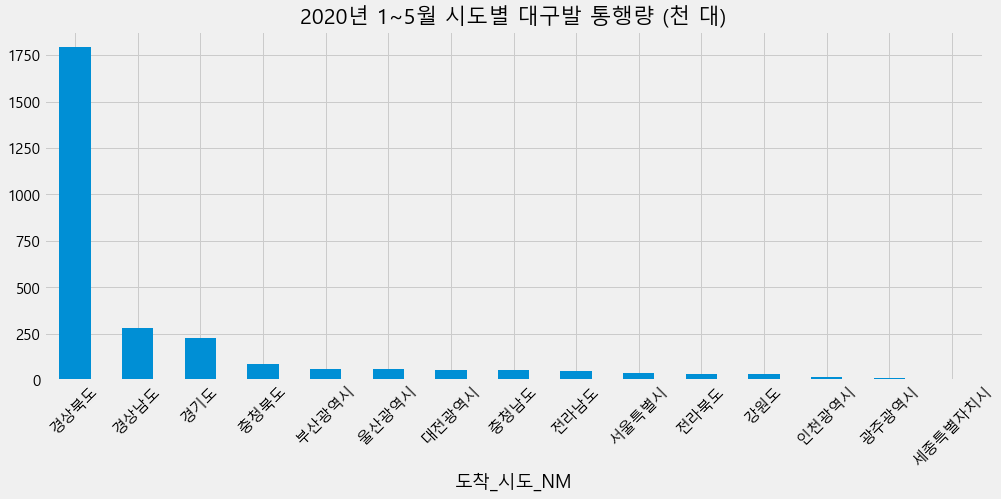

In [27]:
show_infection_case('Shincheonji Church')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(dsrc_df, from_sido='대구광역시', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 대구발 통행량 (천 대)', divide_num=1000)

- **대구에서 발생한 신천지 집단감염 사태는 경상남/북도와 경기도 지역으로 전파**가 높게 일어남
- DSRC 데이터에서도 **대구발 통행량 상위 3위가 경북, 경남, 경기도 지역으로 정확히 일치**하는 것을 확인할 수 있음

사례 : 이태원클럽 (발생지역 : 서울, 용산구)


province,서울,경기도,인천,충청북도,부산,전라북도,경상남도,대구,제주도
Itaewon Clubs,139,59,53,9,4,2,2,2,1


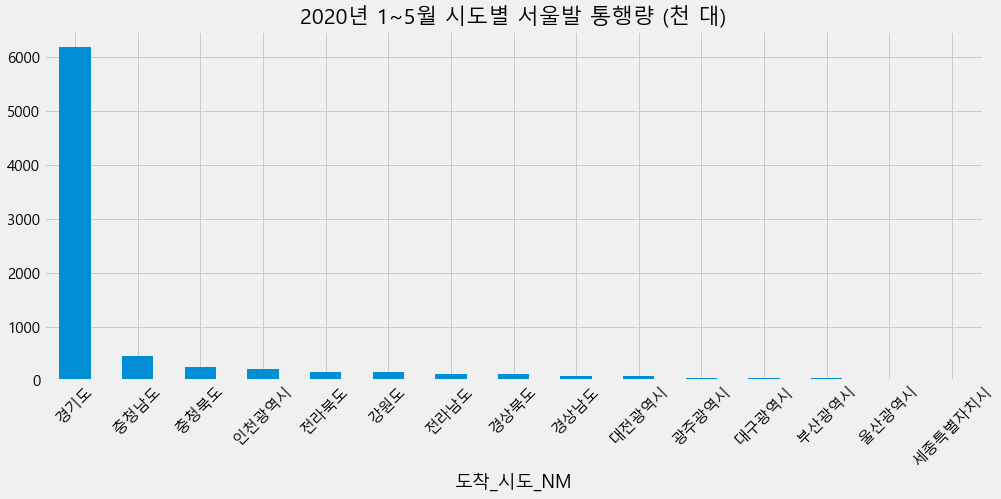

In [28]:
show_infection_case('Itaewon Clubs')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(dsrc_df, from_sido='서울특별시', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 서울발 통행량 (천 대)', divide_num=1000)

- **서울에서 발생한 이태원 클럽 집단감염 사태는 같은 수도권에 속하는 경기/인천 지역에 더해 충청북도로 전파**가 높게 일어남
- DSRC 데이터에서 **서울발 통행량 상위 4위 내에 해당 지역이 모두 포함**되는 것을 확인할 수 있음. 단 역시 통행량이 높게 나타난 충청북도에서는 관련 확진자가 발생하지 않았음

사례 : 구로구 콜센터 (발생지역 : 서울, 구로구)


province,서울,경기도,인천,충청북도
Guro-gu Call Center,95,50,20,2


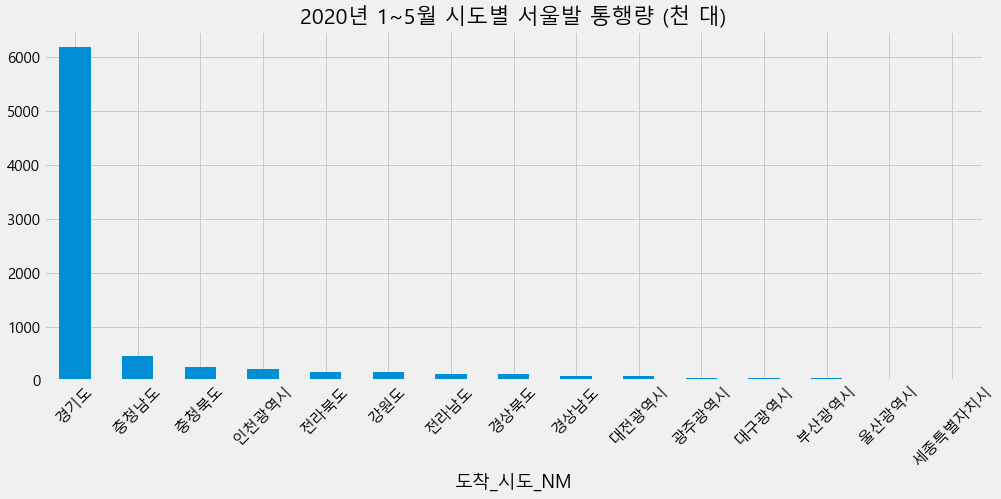

In [29]:
show_infection_case('Guro-gu Call Center')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(dsrc_df, from_sido='서울특별시', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 서울발 통행량 (천 대)', divide_num=1000)

- **서울에서 발생한 구로구 집단감염 사태는 같은 수도권에 속하는 경기/인천 지역에 더해 충청북도로 전파**가 일어남
- DSRC 데이터에서 **서울발 통행량 상위 4위 내에 해당 지역이 모두 포함**되는 것을 확인할 수 있음. 단 역시 통행량이 높게 나타난 충청남도에서는 관련 확진자가 발생하지 않았음

사례 : 쿠팡 물류센터 (발생지역 : 경기도, 부천시)


province,경기도,인천,서울
Coupang Logistics Center,67,42,25


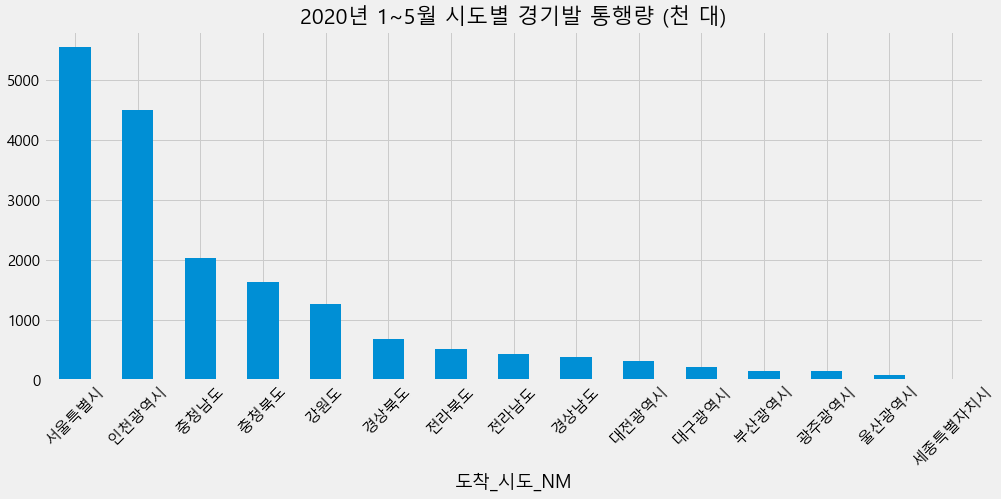

In [30]:
show_infection_case('Coupang Logistics Center')
print('\n')
tmp_traffic_df = plot_traffic_by_sido(dsrc_df, from_sido='경기도', date_range=['2020-01-01', '2020-06-01'], title='2020년 1~5월 시도별 경기발 통행량 (천 대)', divide_num=1000)

- **경기도에서 발생한 쿠팡 물류센터 집단감염 사태는 수도권 내에서 전파**가 집중됨
- DSRC 데이터에서 **경기발 통행량 상위 2개 도시가 수도권 2개 시도로 정확히 일치**하는 것을 확인할 수 있음
<br><br>

<img src="https://icon-library.net/images/insight-icon/insight-icon-27.jpg" height="200"/>
 
### DSRC 데이터 분석 - 소결론
- 차량을 이용한 통행량은 전년 대비 소폭 증가함. **코로나19 확산 이후 타인과 접촉이 적은 자가용 등의 개인적 이동수단을 선호하는 경향이 반영**된 것으로 판단됨
<br><br>

- 시기별로 보았을 때, 발권 OD 데이터와 유사하게 전국적인 대규모 집단감염이 발생하기 직전인 7주차와 18주차에 전주 대비 통행량이 증가함. **전주 대비 통행량이 급증한 주간에 대규모 집단감염 발생 위험이 높아진**다는 사실을 재차 확인할 수 있음
<br><br>

- 지역별로 보았을 때, 발권 OD 데이터와 마찬가지로 특정 지역에서 집단감염이 발생하면 해당 지역과 교통 이동량이 높은 타 지역으로 지역 간 전파가 일어날 가능성이 높음. **한 지역에서 집단감염이 발생한 경우 해당 지역과 교통 이동량이 높은 지역에서 선제적으로 방역 대책을 세우는 것이 유효한 대응일 수 있다**는 사실을 재차 확인할 수 있음.
<br><br>


## 6. 코로나 대확산 선행지표 개발
- 이상의 시기별/지역별 분석을 통해, **지역(시/도) 간 통행량 데이터와 코로나19 확진자 수 데이터 사이의 관련성**을 확인하였음
- 이제 두 데이터 사이에서 발견된 관련성을 이용해, **시기별/지역별 코로나 대확산 선행지표**를 제안하고자 함

### 6-1. 시기별 선행지표 - 주차별 합산 통행 변화량
- 통행량 데이터 분석에서 **주차별 통행량과 주간 코로나19 확진자 수 사이의 관련성**을 확인함
- 보다 정확한 비교를 위해, 각 주차별 전주 대비 통행 변화량을 계산함<br>
(**전주 대비 통행 변화량** : 해당 주차의 통행량에서 전 주차의 통행량을 차감한 값)

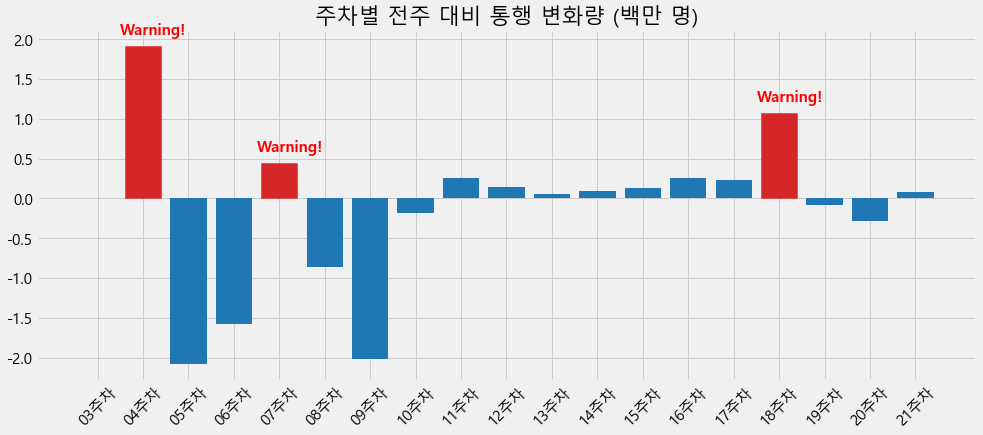

In [31]:
# 발권 OD 데이터 주차별 전주 대비 통행 변화량 시각화
tmp_df = get_weekly_traffic(ticket_df, y_col='TOTAL_TRFC_STF')
tmp_df['pre_week_TRFC'] = [1] + tmp_df['TOTAL_TRFC_STF'].iloc[:-1].tolist()
tmp_df['diff_rate_TRFC'] = tmp_df['TOTAL_TRFC_STF'].subtract(tmp_df['pre_week_TRFC'])

plt.figure(figsize=(15, 6))
barlist = plt.bar(tmp_df.iloc[1:].weekofyear, tmp_df.iloc[1:].diff_rate_TRFC, color='tab:blue')
for x in [1, 4, 15]:
  plt.text(x-0.5, tmp_df.loc[x+1, 'diff_rate_TRFC']+0.15, 'Warning!', color='red', fontweight='bold')
  barlist[x].set_color('tab:red')
plt.title('주차별 전주 대비 통행 변화량 (백만 명)')
plt.xticks(rotation=45)
plt.show()

- 각 주차별로 발권 OD 데이터에서 전국의 직전 주 대비 통행량의 변화량을 계산함
- **직전 주 대비 통행량**은 분석 대상 범위 내에서 **4주차, 7주차, 18주차에 최고치**를 기록함
- 8주차(신천지 사태)와 19주차(이태원 클럽 사태)에 각각 전국적 집단감염이 발발했다는 사실을 고려할 때, **주차별 발권 OD 변화량은 일종의 선행지표가 될 수 있음**을 시사함


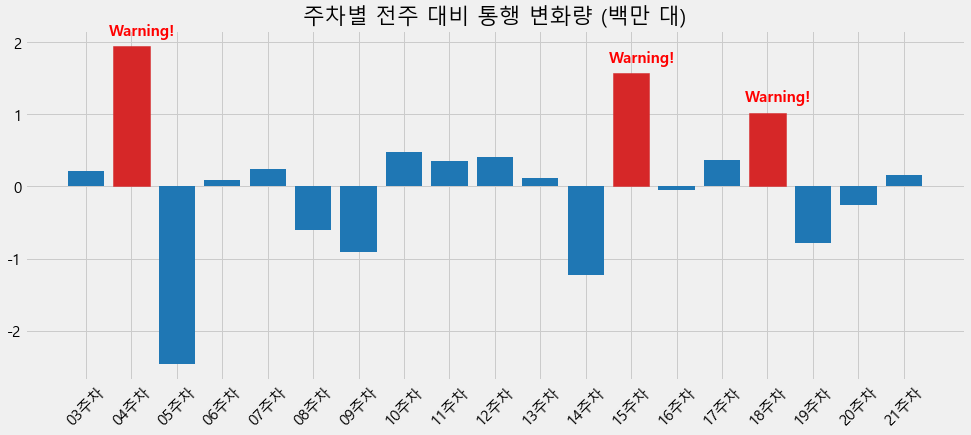

In [32]:
# DSRC 데이터 주차별 전주 대비 통행 변화량 시각화
tmp_df = get_weekly_traffic(dsrc_df, y_col='가상OBU_ID_COUNT', date_col='기준일자')
tmp_df['pre_week_TRFC'] = [1] + tmp_df['가상OBU_ID_COUNT'].iloc[:-1].tolist()
tmp_df['diff_rate_TRFC'] = tmp_df['가상OBU_ID_COUNT'].subtract(tmp_df['pre_week_TRFC'])

plt.figure(figsize=(15, 6))
barlist = plt.bar(tmp_df.iloc[1:].weekofyear, tmp_df.iloc[1:].diff_rate_TRFC, color='tab:blue')
for x in [1, 12, 15]:
  plt.text(x-0.5, tmp_df.loc[x+1, 'diff_rate_TRFC']+0.15, 'Warning!', color='red', fontweight='bold')
  barlist[x].set_color('tab:red')
plt.title('주차별 전주 대비 통행 변화량 (백만 대)')
plt.xticks(rotation=45)
plt.show()

- 각 주차별로 DSRC 데이터에서 전국의 직전 주 대비 통행량의 변화량을 계산함
- **직전 주 대비 통행량**은 분석 대상 범위 내에서 **4주차, 15주차, 18주차에 최고치**를 기록함
- 본 데이터는 19주차(이태원 클럽 사태)의 위험성을 반영하기는 하지만, 발권 OD 데이터만큼 전국적 집단 감염 발발과 관련성이 높다고 보기는 어려움
- 그러나 **전국 시/도간 장거리 이동량을 반영하는 발권 OD 데이터와 유사성이 있기 때문에, 발권 OD 데이터를 보완하는 보조지표로 의미**가 있다고 생각됨
<br><br>

### 6-2. 지역별 선행지표 - 시/도간 평균 통행량

- 통행량 데이터 분석에서 **지역 간 통행량과 지역 간 집단감염 전파량 사이의 관련성**을 확인함
- 발권 OD 데이터, 교통카드 OD 데이터, DSRC 데이터들의 가중평균인 **지역 간 연결성(지역 간 이동 통행량)**이라는 지표를 정의하여, 타 지역에 비해 서로 집단감염 전파 위험도가 높은 지역을 선별하고자 함
- 이렇게 새롭게 정의된 '지역 간 연결성' 지표는,  **특정 지역에서 집단감염 발생 시 우선적으로 방역 대책이 필요한 타 지역을 선정하는 데 활용**될 수 있음
- 이를 통해 **특정 지역의 집단감염이 전국적인 대규모 집단감염으로 번지는 상황을 최소화**할 수 있음
<br><br>

#### < 지역 간 연결성(지역 간 이동 통행량 가중평균) 지표 계산을 위한 데이터 전처리 >
1. 육로가 없는 제주특별자치시를 제외하고, 전국 16개 시/도를 2개씩 묶은 지역 간 연결쌍 key 생성 (ex. 서울-경기, 서울-인천, 서울-강원, etc)
2. 각 key 에 대한 교통 통행량(발권, 교통카드, DSRC)과 코로나19 확진자 수의 합계를 계산

#### < 지역 간 연결성(지역 간 이동 통행량 가중평균) 지표 계산을 위한 가중치 생성 >
- DSRC, 발권OD, 교통카드OD 데이터 간의 다중공선성 확인 후 적합한 선형회귀분석 진행 (Robust Regression)
- 회귀분석 결과로 나온 가중치(weight)를 각 데이터에 곱해 하나의 통합 지표(**지역 간 연결성, "TOTAL_SCORE"**) 계산

In [33]:
# 시도 간 경로 집합 생성
ticket_df['시도_집합'] = ticket_df.apply(lambda x: str(set(sorted([x['출발_시도명'], x['도착_시도명']]))), axis=1)
card_df['시도_집합'] = card_df.apply(lambda x: str(set(sorted([x['출발_시도명'], x['도착_시도명']]))), axis=1)
dsrc_df['시도_집합'] = dsrc_df.apply(lambda x: str(set(sorted([x['출발_시도_NM'], x['도착_시도_NM']]))), axis=1)

# 시도 집합별 통행량
ticket_df_grp = ticket_df.groupby('시도_집합')[['RLRD_TRFC_STF', 'ITCBUS_TRFC_STF', 'EXPBUS_TRFC_STF']].sum().reset_index()
card_df_grp = card_df.groupby('시도_집합')['TRFC_STF'].sum().reset_index()
dsrc_df_grp = dsrc_df.groupby('시도_집합')['가상OBU_ID_COUNT'].sum().reset_index()

# 발권OD, 교통카드OD, DSRC 통합
total_df = dsrc_df_grp.merge(ticket_df_grp, how='left', on='시도_집합')
total_df = total_df.merge(card_df_grp, how='left', on='시도_집합')
total_df.columns = ['시도_집합', 'DSRC', '발권OD_철도', '발권OD_시외버스', '발권OD_고속버스', '교통카드OD']

# 시도_집합 전처리 & 정렬
total_df['시도_집합'] = total_df['시도_집합'].apply(lambda x: sorted(re.sub(r"[\{\}\'\s]", "", x).split(',')))
total_df = total_df.sort_values(by='시도_집합').reset_index(drop=True)
total_df['시도_집합'] = total_df['시도_집합'].apply(lambda x: x * 2 if len(x) == 1 else x)
total_df.fillna(0, inplace=True)
for col in total_df.columns:
    if col != '시도_집합':
        total_df[col] = total_df[col].astype('int64')
        
display(total_df.head(2))

,시도_집합,DSRC,발권OD_철도,발권OD_시외버스,발권OD_고속버스,교통카드OD
0,"[강원도, 강원도]",12897313,432072,2278528,87719,8899074
1,"[강원도, 경기도]",4874508,335003,2243797,109848,575181


In [34]:
# 집단 감염 사례 (제주도 제외)
big_case_df = big_case_df[~big_case_df['province'].isin(['제주도'])]

# 시도명 key값 일치
sido_correct = {'서울': '서울특별시', '부산': '부산광역시', '대구': '대구광역시', '광주': '광주광역시', 
                '인천': '인천광역시', '대전': '대전광역시', '울산': '울산광역시', '세종': '세종특별자치시'}
big_case_df['province'] = big_case_df['province'].apply(lambda x: sido_correct[x] if x in sido_correct.keys() else x)

# 집단 감염 사례 원천 시도명 컬럼 생성
big_case_sido = big_case_df[(big_case_df['city'] != '타도시')][['province', 'infection_case']].drop_duplicates().reset_index(drop=True)
big_case_sido_dict = dict(zip(big_case_sido['infection_case'], big_case_sido['province']))
big_case_df['infection_case_province'] = big_case_df['infection_case'].apply(lambda x: big_case_sido_dict[x])

# 시도_집합 key 컬럼 생성
big_case_df['시도_집합'] = big_case_df.apply(lambda x: str(set(sorted([x['province'], x['infection_case_province']]))), axis=1)

# 시도_집합별 확진자 합
big_case_df_grp = big_case_df.groupby('시도_집합')['confirmed'].sum().reset_index()

# 시도_집합 리스트 변환 및 전처리
big_case_df_grp['시도_집합'] = big_case_df_grp['시도_집합'].apply(lambda x: sorted(re.sub(r"[\{\}\'\s]", "", x).split(',')))
big_case_df_grp = big_case_df_grp.sort_values(by='시도_집합').reset_index(drop=True)
big_case_df_grp['시도_집합'] = big_case_df_grp['시도_집합'].apply(lambda x: x * 2 if len(x) == 1 else x)

# Join을 위한 임시 테이블
total_df_tmp = copy.deepcopy(total_df)
total_df_tmp['시도_집합_str'] = total_df_tmp['시도_집합'].apply(lambda x: str(x))

big_case_df_grp_tmp = copy.deepcopy(big_case_df_grp)
big_case_df_grp_tmp['시도_집합_str'] = big_case_df_grp_tmp['시도_집합'].apply(lambda x: str(x))

# 교통량 데이터 & 확진자 데이터 Join
col_list = ['시도_집합_x', 'DSRC', '발권OD_철도', '발권OD_시외버스', '발권OD_고속버스', '교통카드OD', 'confirmed']
result_df = total_df_tmp.merge(big_case_df_grp_tmp, how='left', on='시도_집합_str')[col_list].fillna(0)
result_df.columns = ['시도_집합', 'DSRC', '발권OD_철도', '발권OD_시외버스', '발권OD_고속버스', '교통카드OD', '확진자']
result_df = result_df[result_df['시도_집합'].apply(lambda x: False if len(set(x)) == 1 else True)]
display(result_df.head())

,시도_집합,DSRC,발권OD_철도,발권OD_시외버스,발권OD_고속버스,교통카드OD,확진자
1,"[강원도, 경기도]",4874508,335003,2243797,109848,575181,0.0
2,"[강원도, 경상남도]",148230,797,42850,7511,0,0.0
3,"[강원도, 경상북도]",412500,122213,146566,468,38,0.0
4,"[강원도, 광주광역시]",35407,0,30395,63041,0,0.0
5,"[강원도, 대구광역시]",169551,20512,178992,99417,0,17.0


,DSRC,발권OD_철도,발권OD_시외버스,발권OD_고속버스,교통카드OD
DSRC,1.000000,0.380486,0.557687,0.196014,0.735039
발권OD_철도,0.380486,1.000000,0.440559,0.740604,0.437563
발권OD_시외버스,0.557687,0.440559,1.000000,0.405813,0.261364
발권OD_고속버스,0.196014,0.740604,0.405813,1.000000,0.297027
교통카드OD,0.735039,0.437563,0.261364,0.297027,1.000000


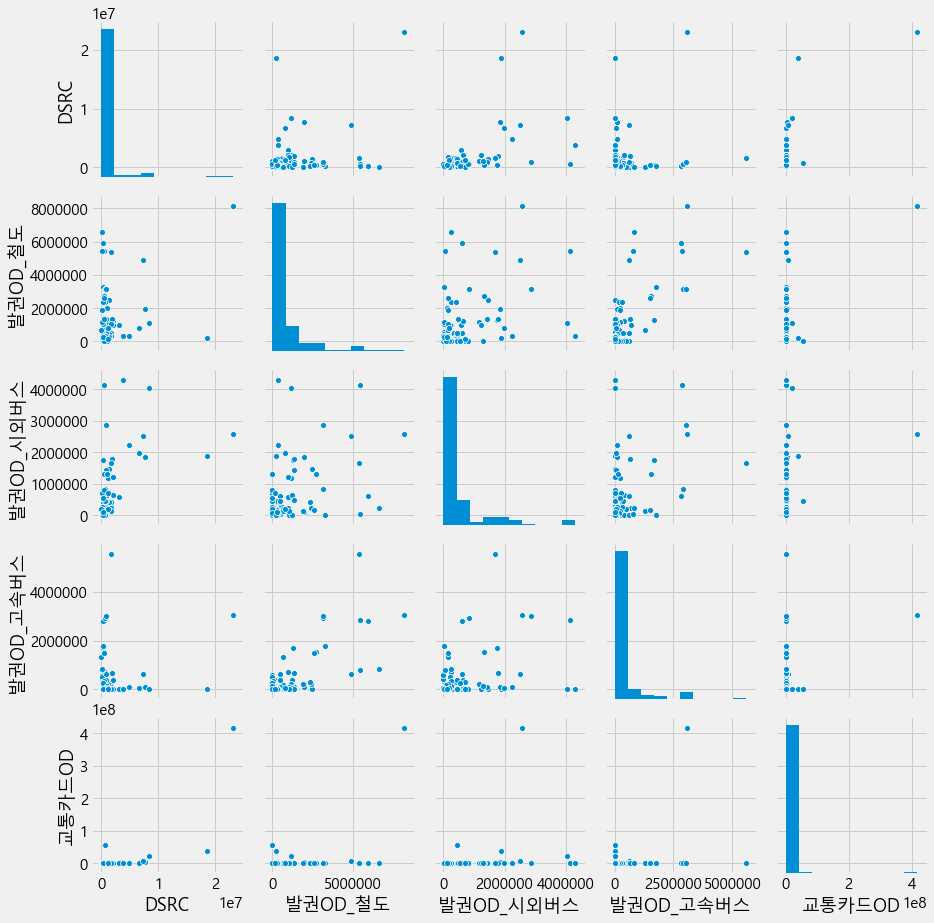

In [35]:
display(result_df.drop(columns=['시도_집합', '확진자']).corr())
sns.pairplot(result_df.drop(columns=['시도_집합', '확진자']))

- 강한 다중공선성이 보이진 않으나, 강한 outlier들이 발견됨
- outlier에 비교적 덜 민감한 Robust Regression 을 활용해, 각 통행량 데이터에 곱해줄 가중치 계산

In [36]:
# r squared 스코어, 5개의 교차검증 fold, 모델 계수 리스트 준비
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
coefficient_list = []

# 교차 검증을 통한 Robust Regression weight 구하기
df = result_df.drop(columns=['시도_집합'])
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    
    # train, test 데이터
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    
    # model 생성
    model = HuberRegressor().fit(df_train.drop(columns='확진자'), df_train['확진자'])
    
    # 예측값 생성
    pred = model.predict(df_test.drop(columns='확진자'))
    
    # train 데이터 R squared 측정
    rsquared_train = model.score(df_train.drop(columns='확진자'), df_train['확진자'])
    
    # test 데이터 R squared 측정
    rsquared_test = model.score(df_test.drop(columns='확진자'), df_test['확진자'])
    
    scores[i] = rsquared_test
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(rsquared_train, rsquared_test))
    print(f'model coefficient : {model.coef_}')
    coefficient_list.append(model.coef_)
    print('\n')

학습 R2 = 0.93362591, 검증 R2 = -0.03466389
model coefficient : [-3.41864523e-07  5.30025473e-07  4.05932579e-07  3.10277869e-07
  4.78627770e-07]


학습 R2 = 0.11011424, 검증 R2 = -0.10294256
model coefficient : [-6.95106750e-08  1.87082880e-07  6.57325113e-07  1.52488250e-07
  4.70485432e-07]


학습 R2 = 0.11193122, 검증 R2 = -0.04684233
model coefficient : [ 1.46566833e-07  5.25020881e-07 -1.19115054e-07 -7.36860532e-08
  4.58324583e-07]


학습 R2 = 0.11134713, 검증 R2 = -0.05663990
model coefficient : [-1.33964799e-07  6.34518442e-07  1.81650693e-07 -4.36803288e-08
  4.69653059e-07]


학습 R2 = 0.03592602, 검증 R2 = -2.26731610
model coefficient : [-5.53727057e-07  5.16309887e-07  9.05203915e-07 -1.37879091e-07
  1.32895471e-06]




- 데이터가 적기 때문에 검증 R squared가 음으로 나옴
- 그 중 학습 R squared가 높은 첫 번째 모델의 coefficient 선택

In [37]:
coefficient = coefficient_list[0]
result_df['TOTAL_SCORE'] = result_df['DSRC']*coefficient[0] + result_df['발권OD_철도']*coefficient[1] + result_df['발권OD_시외버스']*coefficient[2] +\
                           result_df['발권OD_고속버스']*coefficient[3] + result_df['교통카드OD']*coefficient[4]
display(result_df.sort_values(by='TOTAL_SCORE', ascending=False).head())

,시도_집합,DSRC,발권OD_철도,발권OD_시외버스,발권OD_고속버스,교통카드OD,확진자,TOTAL_SCORE
23,"[경기도, 서울특별시]",23100090,8157806,2574763,3052560,416949700,198.0,197.982771
103,"[서울특별시, 인천광역시]",732050,0,445370,0,54604686,73.0,26.065847
26,"[경기도, 인천광역시]",18607470,203347,1893067,4126,37890809,42.0,12.651876
36,"[경상남도, 부산광역시]",8454214,1128038,4040417,0,21854154,0.0,9.807835
8,"[강원도, 서울특별시]",540528,5461520,4137791,2847279,632721,8.0,5.575907


- 회귀모델에서 얻은 coefficient를 각각의 통행량 데이터에 곱해 합산한 값(가중평균)을 TOTAL_SCORE(지역 간 연결성)로 정의
- 최종적으로 계산한 각 지역 간 연결쌍별 TOTAL_SCORE(지역 간 연결성) 지표는 코로나19 지역 간 전파량에 기반해 학습되음
- 따라서, **TOTAL_SCORE(지역 간 연결성) 지표는 곧 지역 간 코로나 전파 위험도를 반영하는 지표**라고 할 수 있음

,시도_집합,TOTAL_SCORE
0,강원도,5.575907
1,경기도,197.982771
2,경상남도,1.806678
3,경상북도,2.299456
4,광주광역시,2.212361


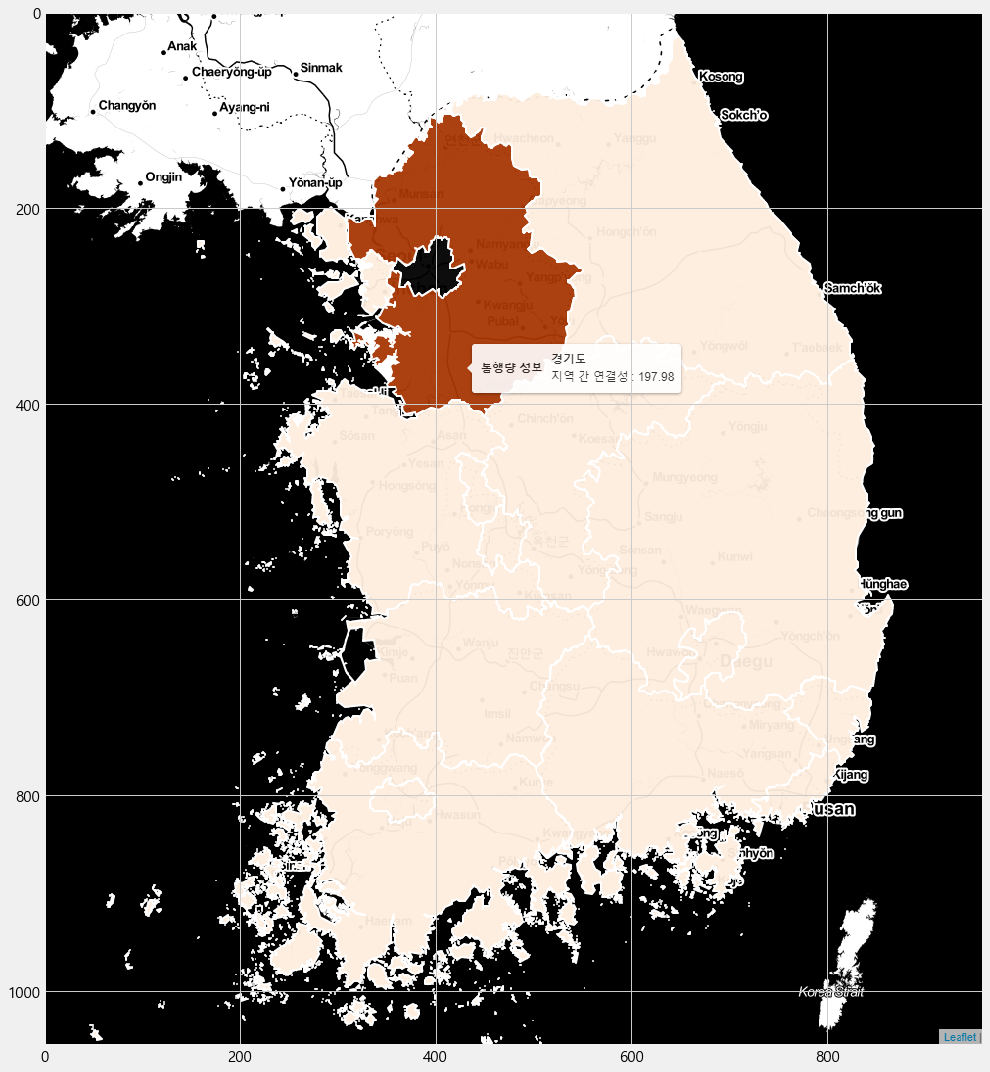

In [38]:
# 서울과 교통 연결성이 높은 Top 5 지역 정보
tmp_sido = '서울특별시'
tmp_val = 'TOTAL_SCORE'

tmp_df = result_df.loc[ result_df.시도_집합.apply(lambda tmp_list : tmp_sido in tmp_list and tmp_list[0]!=tmp_list[1]),
                       ['시도_집합', tmp_val] ].copy()
tmp_df['시도_집합'] = tmp_df['시도_집합'].apply(lambda x : [i for i in x if i!=tmp_sido][0])
display(tmp_df.head(5).reset_index(drop=True))


# 각 시도별 서울과의 연결성 지도 - 용량 한계로 지도 캡쳐 이미지를 대신 출력
tmp_gdf = merge_gdf(main_gdf=district_geo_df, value_df=tmp_df, right_on='시도_집합', divide_num=1)
title, map1 = plot_choropleth_by_sido(tmp_gdf, value_col=tmp_val, sido_col='CTP_KOR_NM')
map1.save(f'{title}.html')

# 지도 파일에서 직접 캡쳐한 이미지 출력
map_img = Image.open(f'{title}.png')
plt.figure(figsize=(15, 20))
plt.imshow(map_img)
plt.show()

- 서울과 '지역 간 연결성'이 높은 지역은 경기도, 인천 지역

,시도_집합,TOTAL_SCORE
0,강원도,0.056414
1,경기도,0.827087
2,경상남도,0.755797
3,경상북도,5.105992
4,광주광역시,0.076617


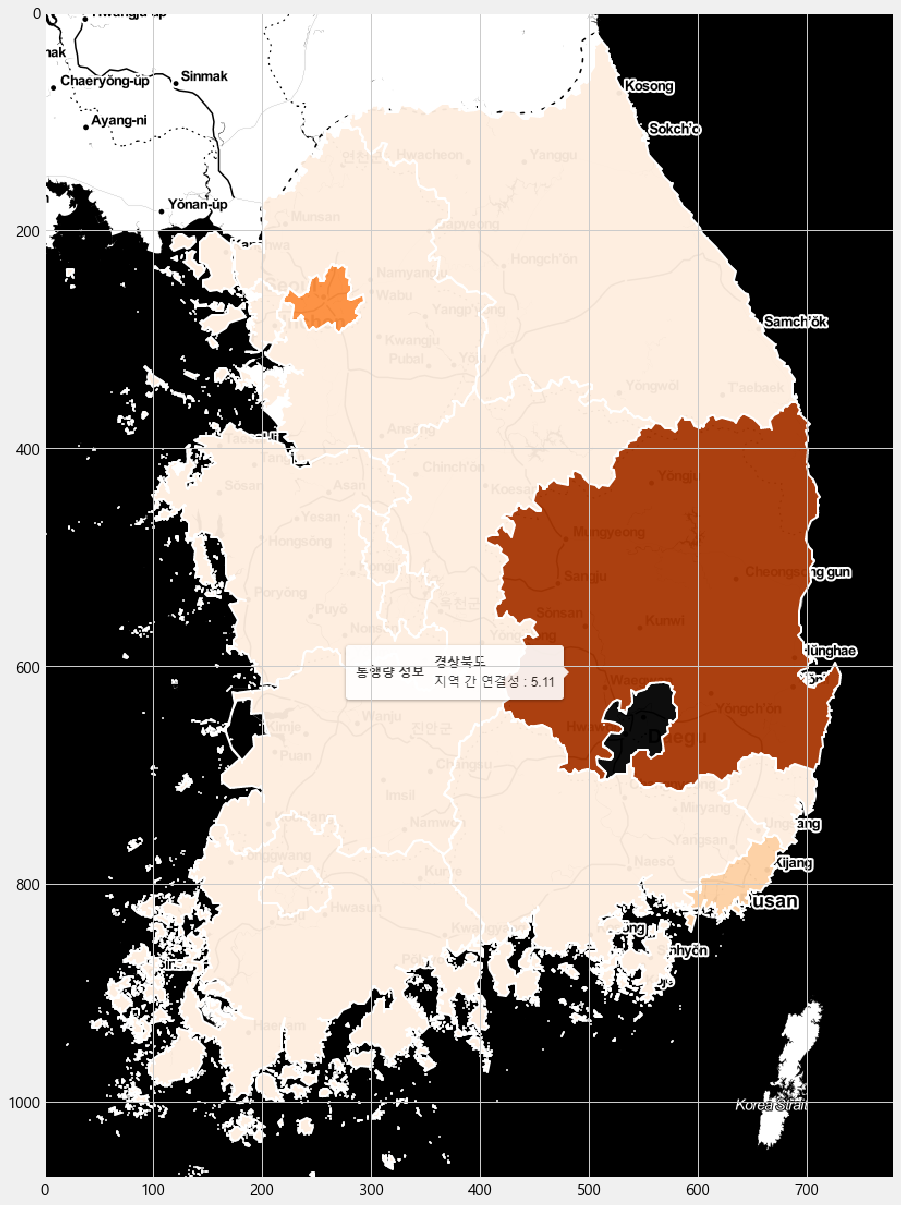

In [39]:
# 대구와 교통 연결성이 높은 Top 5 지역 정보
tmp_sido = '대구광역시'
tmp_val = 'TOTAL_SCORE'

tmp_df = result_df.loc[ result_df.시도_집합.apply(lambda tmp_list : tmp_sido in tmp_list and tmp_list[0]!=tmp_list[1]),
                       ['시도_집합', tmp_val] ].copy()
tmp_df['시도_집합'] = tmp_df['시도_집합'].apply(lambda x : [i for i in x if i!=tmp_sido][0])
display(tmp_df.head(5).reset_index(drop=True))


# 각 시도별 대구와의 연결성 지도 - 용량 한계로 지도 캡쳐 이미지를 대신 출력
tmp_gdf = merge_gdf(main_gdf=district_geo_df, value_df=tmp_df, right_on='시도_집합', divide_num=1)
title, map1 = plot_choropleth_by_sido(tmp_gdf, value_col=tmp_val, sido_col='CTP_KOR_NM')
map1.save(f'{title}.html')

# 지도 파일에서 직접 캡쳐한 이미지 출력
map_img = Image.open(f'{title}.png')
plt.figure(figsize=(15, 20))
plt.imshow(map_img)
plt.show()

- 대구와 '지역 간 연결성'이 높은 지역은 경북, 서울 지역

,시도_집합,TOTAL_SCORE
0,강원도,0.066553
1,경기도,1.446004
2,경상남도,0.217716
3,경상북도,0.402970
4,광주광역시,0.116578


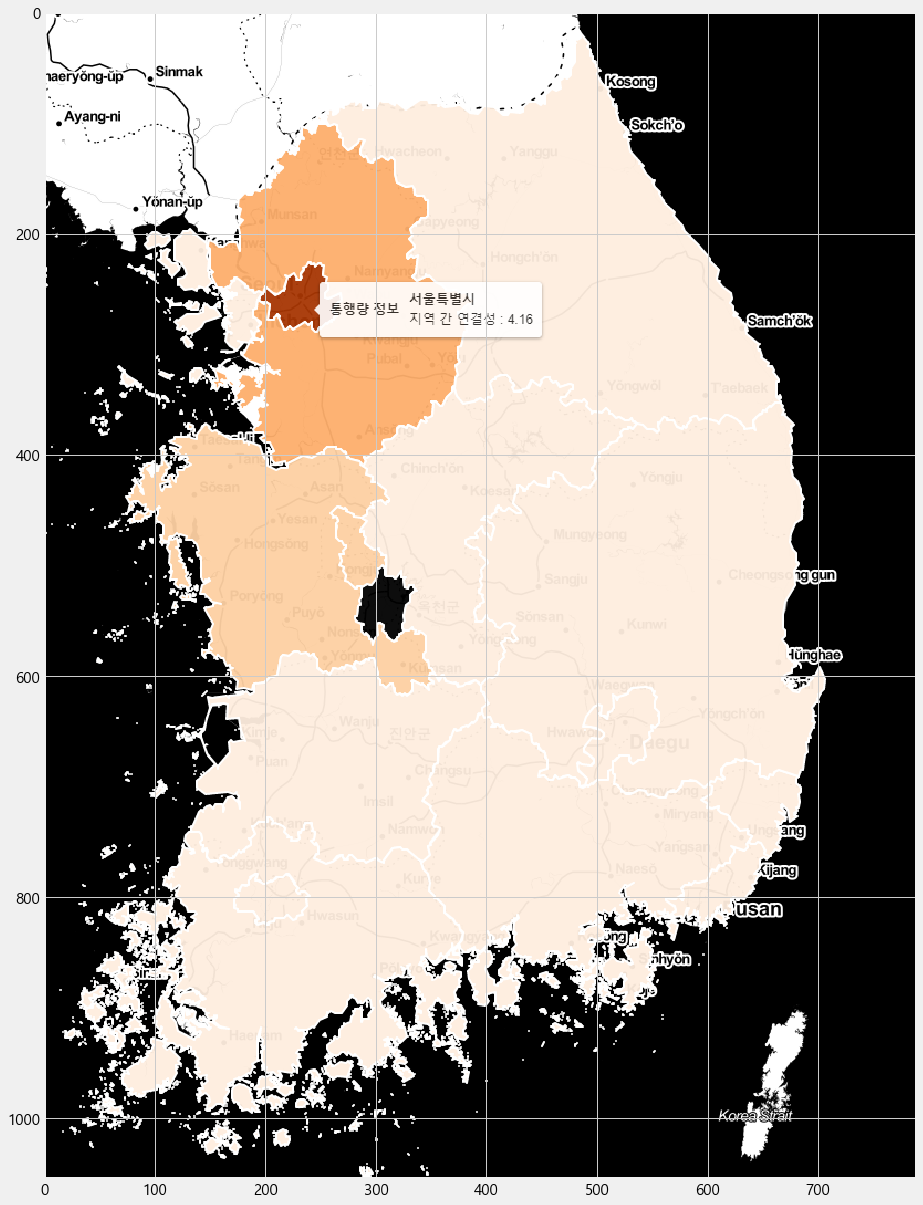

In [40]:
# 대전과 교통 연결성이 높은 Top 5 지역 정보
tmp_sido = '대전광역시'
tmp_val = 'TOTAL_SCORE'

tmp_df = result_df.loc[ result_df.시도_집합.apply(lambda tmp_list : tmp_sido in tmp_list and tmp_list[0]!=tmp_list[1]),
                       ['시도_집합', tmp_val] ].copy()
tmp_df['시도_집합'] = tmp_df['시도_집합'].apply(lambda x : [i for i in x if i!=tmp_sido][0])
display(tmp_df.head(5).reset_index(drop=True))


# 각 시도별 대전과의 연결성 지도 - 용량 한계로 지도 캡쳐 이미지를 대신 출력
tmp_gdf = merge_gdf(main_gdf=district_geo_df, value_df=tmp_df, right_on='시도_집합', divide_num=1)
title, map1 = plot_choropleth_by_sido(tmp_gdf, value_col=tmp_val, sido_col='CTP_KOR_NM')
map1.save(f'{title}.html')

# 지도 파일에서 직접 캡쳐한 이미지 출력
map_img = Image.open(f'{title}.png')
plt.figure(figsize=(15, 20))
plt.imshow(map_img)
plt.show()

- 대전과 '지역 간 연결성'이 높은 지역은 서울, 경기, 충남, 세종 지역

## 7. 결론
- 본 분석에서 코로나19 데이터와 전국 통행량 데이터를 분석함으로써 확인한 사실들은 아래와 같음
1. 시기별로 보았을 때, **전 주 대비 교통량이 급증한 주간에 대규모 집단감염이 발생할 위험**이 높아졌다
2. 지역별로 보았을 때, **대중교통/고속도로 이동량으로 확인되는 "지역 간 연결성"이 서로 높은 지역들은 "코로나19 지역 간 전파"가 발생할 위험** 또한 높아졌다.
<br><br>

- 이상의 사실들을 바탕으로, 아래와 같은 지표들이 선제적 방역 대책을 수립하는 데 활용될 수 있을 것으로 기대됨
1. **주차별 직전 주 대비 교통 변화량 → 대규모 집단감염 발발 위험도 반영**
2. **지역별 타 지역과의 교통량(지역 간 연결성) → 집단감염 발발 시 전파 위험성이 높은 타 지역**

<br><br>
<img src='http://58.234.158.21:8081/Upload/Image/20200220/00000000000000085168.jpg' height="300"/>
<br><br>

- 현재 방역대책은 주로 집단감염이 발생한 이후에 확진자들의 동선을 중심으로 역추적하거나 과거 집단감염이 발생한 장소들을 소독하는 등 **사후적 대책**이 주를 이루고 있음. 코로나19의 증상 발현이 감염 이후 1~2주라는 점을 고려한다면 확진자들이 집단적으로 증세를 보인 시점 이후에 적용되는 현 대책들은 한계가 있을 수 밖에 없으며, 수행 시간도 많이 소요되는 것들이 다수임.
- 본 지표들이 완벽한 예측 지표라고 할 수는 없어도, 매주 **전주 대비 통행량의 변화를 모니터링** 하거나 **지역 간 이동 교통량(지역 간 연결성)을 모니터링**함으로써 아래의 대시보드 사례처럼 일종의 **사전 경보 체계(대시보드)**로 활용될 수 있음
- 향후 시군구, 읍면동까지 세부적으로 연결된 교통량 데이터와 최근 광화문발 집단 감염 데이터를 확보하여 반영한다면, 코로나19와 교통량 간의 면밀한 관계를 파악할 수 있는 통합 대시보드 발전 가능


- 이상의 사전적 지표들을 참고해 **시기적, 지역적인 선제적 방역 대책**이 적용된다면, 추후 **국지적 집단감염 발발 시 전국 단위로 퍼져나갈 가능성을 줄이는 데 기여**할 것으로 기대됨


### 코로나19 대시보드 사례

<img src="https://www.esrikr.com/wp-content/uploads/2020/03/한국-대시보드.jpg" width="1000">

출처: https://www.esrikr.com/blog/corona-virus-korean-dashboard/

'본 저작물의 저작권은 Apache License v2.0을 따릅니다'